# Normed Standardized Comparison Analysis

In [1]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"

### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy
import pickle
from sklearn import preprocessing
import sklearn
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
from sklearn import neighbors
import matplotlib_venn
from sklearn.cross_validation import train_test_split
from random import shuffle

### notebook specific configuration ###
%matplotlib inline
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(5000)
os.chdir('/gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/')
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2
%env PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin:/home/jtao/software/lsgkm/bin

env: PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin:/home/jtao/software/lsgkm/bin


## Functions

In [2]:
# split data into GC content matched training and test data
def get_GC_matched_split(features, labels, test_size, tolerance = 0.01):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    tolerance: max difference in GC content between True and False labelled samples
    '''
    global _id_sequence_dict
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if x[1]]
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if not x[1]]
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
    
    # calculate GC content of True samples
    true_gc_count = 0
    true_length = 0
    for s in true_sequences:
        true_gc_count += s.count('G')
        true_gc_count += s.count('C')
        true_length += len(s)
    true_gc_content = true_gc_count/(true_length+0.0000001)
#     print('Target GC Content: ', true_gc_content)
    # calcuate GC content of False samples
    false_gc_count = 0
    false_length = 0
    for s in false_sequences:
        false_gc_count += s.count('G')
        false_gc_count += s.count('C')
        false_length += len(s)
    false_gc_content = false_gc_count/(false_length+0.0000001)
    
    while abs(true_gc_content - false_gc_content) > tolerance:
        # remove false GC sequences until GC content matches tolerance
        selected_seq = False
        
        while not selected_seq:
            rand_index = np.random.randint(len(false_sequences))
            current_seq = false_sequences[rand_index]
            current_gc_count = current_seq.count('G')+ current_seq.count('C')
            current_length = len(current_seq)
            current_gc = current_gc_count/current_length
            if true_gc_content > false_gc_content:
                # remove sequences that would increase overall GC content of False sequences
                if current_gc < false_gc_content:
                    selected_seq = True
            else:
                # remove sequences that would decrease overall GC content of False sequences
                if current_gc > false_gc_content:
                    selected_seq = True
        false_gc_count -= current_gc_count
        false_length -= current_length
        false_gc_content = false_gc_count/false_length
        
        false_sequences.pop(rand_index)
        false_ids.pop(rand_index)
    
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    return training_features, test_features, training_labels, test_labels
    

In [3]:
# split data into GC content matched training and test data
def get_split(features, labels, test_size):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    '''
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
       
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    return training_features, test_features, training_labels, test_labels
    

In [4]:
def signmoid(x):
    result = 1/(1 + np.exp(-x))
    return result

In [5]:
def quantileNormalize(vals1, vals2):
    '''
    input: two scalar arrays
    output: two quantile normalized scalar arrays
    '''
    vals1 = np.array(vals1)
    vals2 = np.array(vals2)
    
    ranks_1 = scipy.stats.rankdata(vals1, method = 'ordinal')
    ranks_2 = scipy.stats.rankdata(vals2, method = 'ordinal')
    
    sorted_vals_1 = sorted(vals1)
    sorted_vals_2 = sorted(vals2)
    means = np.mean([sorted_vals_1,sorted_vals_2], axis=0)
    
    rank_mean_dict = dict(zip(sorted(ranks_1), sorted(means)))
    normalized_vals_1 = np.array([rank_mean_dict[x] for x in ranks_1])
    normalized_vals_2 = np.array([rank_mean_dict[x] for x in ranks_2])
    return normalized_vals_1, normalized_vals_2

def calcMAD(vals):
    '''
    inputs: an array of scalars
    output: median absolute deviation of input array
    Calculates MAD, the median of the absolute values 
    of the differences between the data values and the 
    overall median of the data set
    '''
    overall_median = np.median(vals)
    absolute_distances = [abs(x-overall_median) for x in vals]
    mad = np.median(absolute_distances)
    return mad

def medNormalize(vals1, vals2):
    med_1 = np.median(vals1)
    med_2 = np.median(vals2)
    if med_1 > med_2:
        corrected_vals1 = vals1
        corrected_vals2 = vals2 + (med_1 - med_2)
    else:
        corrected_vals1 = vals1+ (med_2 - med_1)
        corrected_vals2 = vals2
    return corrected_vals1, corrected_vals2

## Copy Score Files

In [6]:
%%bash
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_score_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_sequence_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_strand_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_start_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_end_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/summary_frame.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/annotation_frame.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/peak_sequences/C57BL6J.fa ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_count_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_summedScore_frame_C57BL6J.pickle ./

In [7]:
%%bash
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_score_frame_BALBCJ.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_sequence_frame_BALBCJ.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_strand_frame_BALBCJ.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_start_frame_BALBCJ.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_end_frame_BALBCJ.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/summary_frame.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/annotation_frame.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/peak_sequences/BALBCJ.fa ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_count_frame_BALBCJ.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_summedScore_frame_BALBCJ.pickle ./

## Read in Score Files

### C57Bl6 Data

In [9]:
motif_score_frame=pd.read_pickle('motif_score_frame_C57BL6J.pickle')
motif_sequence_frame = pd.read_pickle('motif_sequence_frame_C57BL6J.pickle')
motif_strand_frame = pd.read_pickle('motif_strand_frame_C57BL6J.pickle')
motif_start_frame = pd.read_pickle('motif_start_frame_C57BL6J.pickle')
motif_end_frame = pd.read_pickle('motif_end_frame_C57BL6J.pickle')
motif_count_frame = pd.read_pickle('motif_count_frame_C57BL6J.pickle')
summary_frame = pd.read_pickle('summary_frame.pickle')
annotation_frame = pd.read_pickle('annotation_frame.pickle')
motif_summedScore_frame=pd.read_pickle('motif_summedScore_frame_C57BL6J.pickle')

### read in sequences as dictionary {peakID: sequence}
with open('./C57BL6J.fa') as f:
    data = f.readlines()

_id_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()  

### Background Data

In [10]:
strain = 'C57BL6J'
motif_score_background_frame = pd.read_pickle('motif_score_background_frame_'+  strain + '.pickle')
motif_sequence_background_frame=pd.read_pickle('motif_sequence_background_frame_'+  strain + '.pickle')
motif_strand_background_frame=pd.read_pickle('motif_strand_background_frame_'+  strain + '.pickle')
motif_start_background_frame=pd.read_pickle('motif_start_background_frame_'+  strain + '.pickle')
motif_end_background_frame=pd.read_pickle('motif_end_background_frame_'+  strain + '.pickle')
motif_count_background_frame=pd.read_pickle('motif_count_background_frame_'+  strain + '.pickle')
motif_summedScore_background_frame=pd.read_pickle('motif_summedScore_background_frame_'+  strain + '.pickle')



## Normalize Data

In [91]:
# make sure background frames don't have IDs that overlap with target frame
motif_score_background_frame = motif_score_background_frame[~motif_score_background_frame.index.isin(motif_score_frame.index.values)]
motif_sequence_background_frame = motif_sequence_background_frame[~motif_sequence_background_frame.index.isin(motif_score_frame.index.values)]
motif_strand_background_frame = motif_strand_background_frame[~motif_strand_background_frame.index.isin(motif_score_frame.index.values)]
motif_start_background_frame = motif_start_background_frame[~motif_start_background_frame.index.isin(motif_score_frame.index.values)]
motif_end_background_frame = motif_end_background_frame[~motif_end_background_frame.index.isin(motif_score_frame.index.values)]
motif_count_background_frame = motif_count_background_frame[~motif_count_background_frame.index.isin(motif_score_frame.index.values)]
motif_summedScore_background_frame = motif_summedScore_background_frame[~motif_summedScore_background_frame.index.isin(motif_score_frame.index.values)]

In [97]:
# concatent target and background frames
all_score_frame = pd.concat([motif_score_frame, motif_score_background_frame])
all_summedScore_frame = pd.concat([motif_summedScore_frame, motif_summedScore_background_frame])

scaler = preprocessing.StandardScaler()
all_standardized_score_frame = pd.DataFrame(scaler.fit_transform(all_score_frame.ix[:,3:]))
all_standardized_score_frame.columns = all_score_frame.columns.values[3:]
all_standardized_score_frame.index = all_score_frame.index.values

scaler = preprocessing.MinMaxScaler()
all_normed_score_frame = pd.DataFrame(scaler.fit_transform(all_score_frame.ix[:,3:]))
all_normed_score_frame.columns = all_score_frame.columns.values[3:]
all_normed_score_frame.index = all_score_frame.index.values

scaler = preprocessing.StandardScaler()
all_standardized_summedScore_frame = pd.DataFrame(scaler.fit_transform(all_summedScore_frame.ix[:,3:]))
all_standardized_summedScore_frame.columns = all_summedScore_frame.columns.values[3:]
all_standardized_summedScore_frame.index = all_summedScore_frame.index.values

scaler = preprocessing.MinMaxScaler()
all_normed_summedScore_frame = pd.DataFrame(scaler.fit_transform(all_summedScore_frame.ix[:,3:]))
all_normed_summedScore_frame.columns = all_summedScore_frame.columns.values[3:]
all_normed_summedScore_frame.index = all_summedScore_frame.index.values

In [118]:
scaler = preprocessing.MinMaxScaler()
normed_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
normed_motif_frame.columns = motif_score_frame.columns.values[3:]
normed_motif_frame.index = motif_score_frame.index.values

# scaler = preprocessing.StandardScaler()
# standardized_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
# standardized_motif_frame.columns = motif_score_frame.columns.values[3:]
# standardized_motif_frame.index = motif_score_frame.index.values

scaler = preprocessing.MinMaxScaler()
normed_summedScore_frame = pd.DataFrame(scaler.fit_transform(motif_summedScore_frame.ix[:,3:]))
normed_summedScore_frame.columns = motif_summedScore_frame.columns.values[3:]
normed_summedScore_frame.index = motif_summedScore_frame.index.values

# scaler = preprocessing.StandardScaler()
# standardized_summedScore_frame = pd.DataFrame(scaler.fit_transform(motif_summedScore_frame.ix[:,3:]))
# standardized_summedScore_frame.columns = motif_summedScore_frame.columns.values[3:]
# standardized_summedScore_frame.index = motif_summedScore_frame.index.values

In [119]:
# scaler = preprocessing.StandardScaler()
# standardized_motif_background_frame = pd.DataFrame(scaler.fit_transform(motif_score_background_frame.ix[:,3:]))
# standardized_motif_background_frame.columns = motif_score_background_frame.columns.values[3:]
# standardized_motif_background_frame.index = motif_score_background_frame.index.values
scaler = preprocessing.MinMaxScaler()
normed_motif_background_frame = pd.DataFrame(scaler.fit_transform(motif_score_background_frame.ix[:,3:]))
normed_motif_background_frame.columns = motif_score_background_frame.columns.values[3:]
normed_motif_background_frame.index = motif_score_background_frame.index.values
# scaler = preprocessing.StandardScaler()
# standardized_summedScore_background_frame = pd.DataFrame(scaler.fit_transform(motif_summedScore_background_frame.ix[:,3:]))
# standardized_summedScore_background_frame.columns = motif_summedScore_background_frame.columns.values[3:]
# standardized_summedScore_background_frame.index = motif_summedScore_background_frame.index.values
scaler = preprocessing.MinMaxScaler()
normed_summedScore_background_frame = pd.DataFrame(scaler.fit_transform(motif_summedScore_background_frame.ix[:,3:]))
normed_summedScore_background_frame.columns = motif_summedScore_background_frame.columns.values[3:]
normed_summedScore_background_frame.index = motif_summedScore_background_frame.index.values

## Normalized Motifs

### Combined Classifier and Subcomponents

In [22]:
numIterations = 5
test_size = 0.5
background_ratio = 1.0
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    

In [ ]:
auc_normed_list = []
monomer_normed_list = []
treatment_normed_list = []
feature_normed_list = []
# for monomers using all motifs
strain = 'c57bl6'
factor_coeff_normed_affinity_dict = {}
factor_coeff_normed_count_dict = {}
for treatment in ['veh']:
    for monomer in ['atf3', 'cjun', 'jund', 'pu1', 'cebpa']:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        target_features = normed_motif_frame[normed_motif_frame.index.isin(target_indices)]
        background_indices = normed_motif_background_frame.index.values 
        shuffle(background_indices)
        background_indices = background_indices[:background_ratio*len(target_indices)]
        background_features = normed_motif_background_frame[normed_motif_background_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        affinity_features = pd.concat([target_features, background_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
        all_aucs = []
        all_count_aucs = []
        all_affinity_aucs = []
        all_coefficients = []
        all_count_coefficients = []
        all_affinity_coefficients = []
        all_precisions = []
        for i in range(numIterations):
            # split data into training and test sets
            training_affinity_features, test_affinity_features, training_labels, test_labels = get_split(
                affinity_features, labels, test_size = test_size)

            training_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(training_affinity_features.index.values)].ix[:,3:],
                                                 motif_count_background_frame[motif_count_background_frame.index.isin(training_affinity_features.index.values)].ix[:,3:]])
            test_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(test_affinity_features.index.values)].ix[:,3:],
                                             motif_count_background_frame[motif_count_background_frame.index.isin(test_affinity_features.index.values)].ix[:,3:]])
            #  Train affinity classifier
            affinity_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            affinity_classifier.fit(training_affinity_features, training_labels)

            # Train count classifier
            count_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            count_classifier.fit(training_count_features, training_labels)

            # train combined classifier
            training_affinity_scores = affinity_classifier.decision_function(training_affinity_features)
            training_count_scores = count_classifier.decision_function(training_count_features)
            training_combined_features = pd.DataFrame({'Affinity':training_affinity_scores,
                                             'Count':training_count_scores})
            scaler = preprocessing.StandardScaler()
            training_combined_standardized_features = pd.DataFrame(scaler.fit_transform(training_combined_features[['Affinity', 'Count']]))
            training_combined_standardized_features.index = training_combined_features.index.values
            training_combined_standardized_features.columns = training_combined_features.columns.values
            combined_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            combined_classifier.fit(training_combined_standardized_features, training_labels)
            print('affinity, count', combined_classifier.coef_.flatten())

            # retrieve test probabilities
            test_affinity_scores = affinity_classifier.decision_function(test_affinity_features)
            test_count_scores = count_classifier.decision_function(test_count_features)
            test_combined_features = pd.DataFrame({'Affinity':test_affinity_scores,
                                                       'Count':test_count_scores})
            scaler = preprocessing.StandardScaler()
            test_combined_standardized_features = pd.DataFrame(scaler.fit_transform(test_combined_features[['Affinity', 'Count']]))
            test_combined_standardized_features.index = test_combined_features.index.values
            test_combined_standardized_features.columns = test_combined_features.columns.values
            probas = combined_classifier.predict_proba(test_combined_features)
            affinity_probas = affinity_classifier.predict_proba(test_affinity_features)
            count_probas = count_classifier.predict_proba(test_count_features)
            
            # score predictions
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas[:, 1], average = None)
            affinity_roc_auc = sklearn.metrics.roc_auc_score(test_labels, affinity_probas[:, 1], average = None)
            count_roc_auc = sklearn.metrics.roc_auc_score(test_labels, count_probas[:, 1], average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)

            all_aucs.append(current_roc_auc)
            all_count_aucs.append(count_roc_auc)
            all_affinity_aucs.append(affinity_roc_auc)
            all_precisions.append(current_precision)
            
            affinity_coefficients = affinity_classifier.coef_.flatten()
            all_affinity_coefficients.append(affinity_coefficients)
            count_coefficients = count_classifier.coef_.flatten()
            all_count_coefficients.append(count_coefficients)
                
            auc_normed_list = auc_normed_list + [current_roc_auc, count_roc_auc, affinity_roc_auc]
            monomer_normed_list = monomer_normed_list + 3*[monomer]
            treatment_normed_list = treatment_normed_list + 3*[treatment]
            feature_normed_list = feature_normed_list + ['Both', 'Count', 'Affinity']
            
        mean_coefficients = np.mean(all_coefficients, axis=0)
        factor_coeff_normed_affinity_dict[monomer + '_' + treatment] = np.mean(all_affinity_coefficients, axis = 0)
        factor_coeff_normed_count_dict[monomer + '_' + treatment] = np.mean(all_count_coefficients, axis = 0)
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_aucs), np.mean(all_affinity_aucs), np.mean(all_count_aucs),
              'precision:', np.mean(all_precisions), np.var(all_precisions),  
             )
        

### Summed Scores

In [ ]:
# for monomers using all motifs
strain = 'c57bl6'
factor_coeff_normed_summedScore_dict = {}
for treatment in ['veh']:
    for monomer in ['atf3', 'cjun', 'jund', 'pu1', 'cebpa']:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        target_features = normed_summedScore_frame[normed_summedScore_frame.index.isin(target_indices)]
        background_indices = normed_summedScore_background_frame.index.values     # select subset of background indices to use
        
        shuffle(background_indices)
        background_indices = background_indices[:background_ratio*len(target_indices)]
        background_features = normed_summedScore_background_frame[normed_summedScore_background_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        affinity_features = pd.concat([target_features, background_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
        all_aucs = []
        all_coefficients = []
        all_precisions = []
        for i in range(numIterations):

            # split data into training and test sets
            training_affinity_features, test_affinity_features, training_labels, test_labels = get_split(
                affinity_features, labels, test_size = test_size)
            #  Train affinity classifier
            affinity_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            affinity_classifier.fit(training_affinity_features, training_labels)

            probas = affinity_classifier.predict_proba(test_affinity_features)
            # score predictions
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas[:, 1], average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)

            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)
            current_coefficients = affinity_classifier.coef_.flatten()
            all_coefficients.append(current_coefficients)
            
            auc_normed_list.append(current_roc_auc)
            monomer_normed_list.append(monomer)
            treatment_normed_list.append(treatment)
            feature_normed_list.append('Summed Affinity')
                
        mean_coefficients = np.mean(all_coefficients, axis=0)
        factor_coeff_normed_summedScore_dict[monomer + '_' + treatment] = mean_coefficients
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_aucs), np.var(all_aucs),
              'precision:', np.mean(all_precisions), np.var(all_precisions),  
              'numTestPositives:', np.sum(test_labels)
             )
        

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(0.5, 1.01)

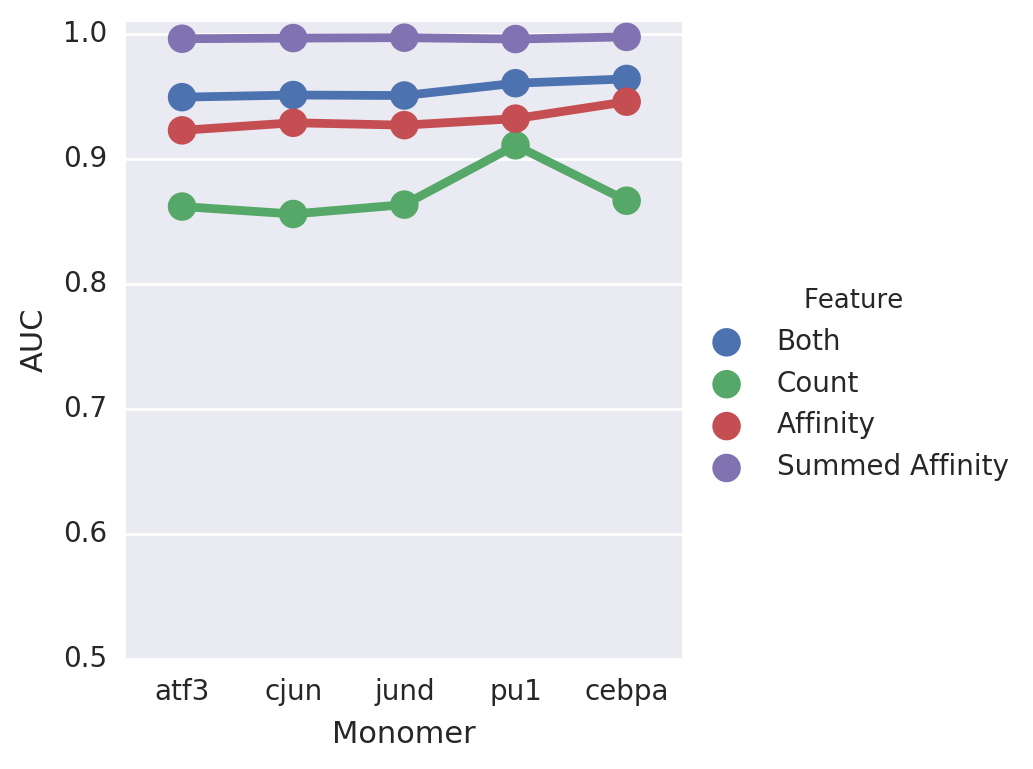

In [84]:
performance_frame = pd.DataFrame({'AUC':auc_normed_list,
                                  'Monomer':monomer_normed_list,
                                  'Treatment':treatment_normed_list,
                                  'Feature':feature_normed_list})
sns.factorplot(data=performance_frame, 
               x='Monomer', 
               y= 'AUC', 
#                col='Treatment', 
               hue='Feature')
plt.ylim(0.5,1.01)

### Visualize Coefficients

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/seaborn-0.7.1-py3.5.egg/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:


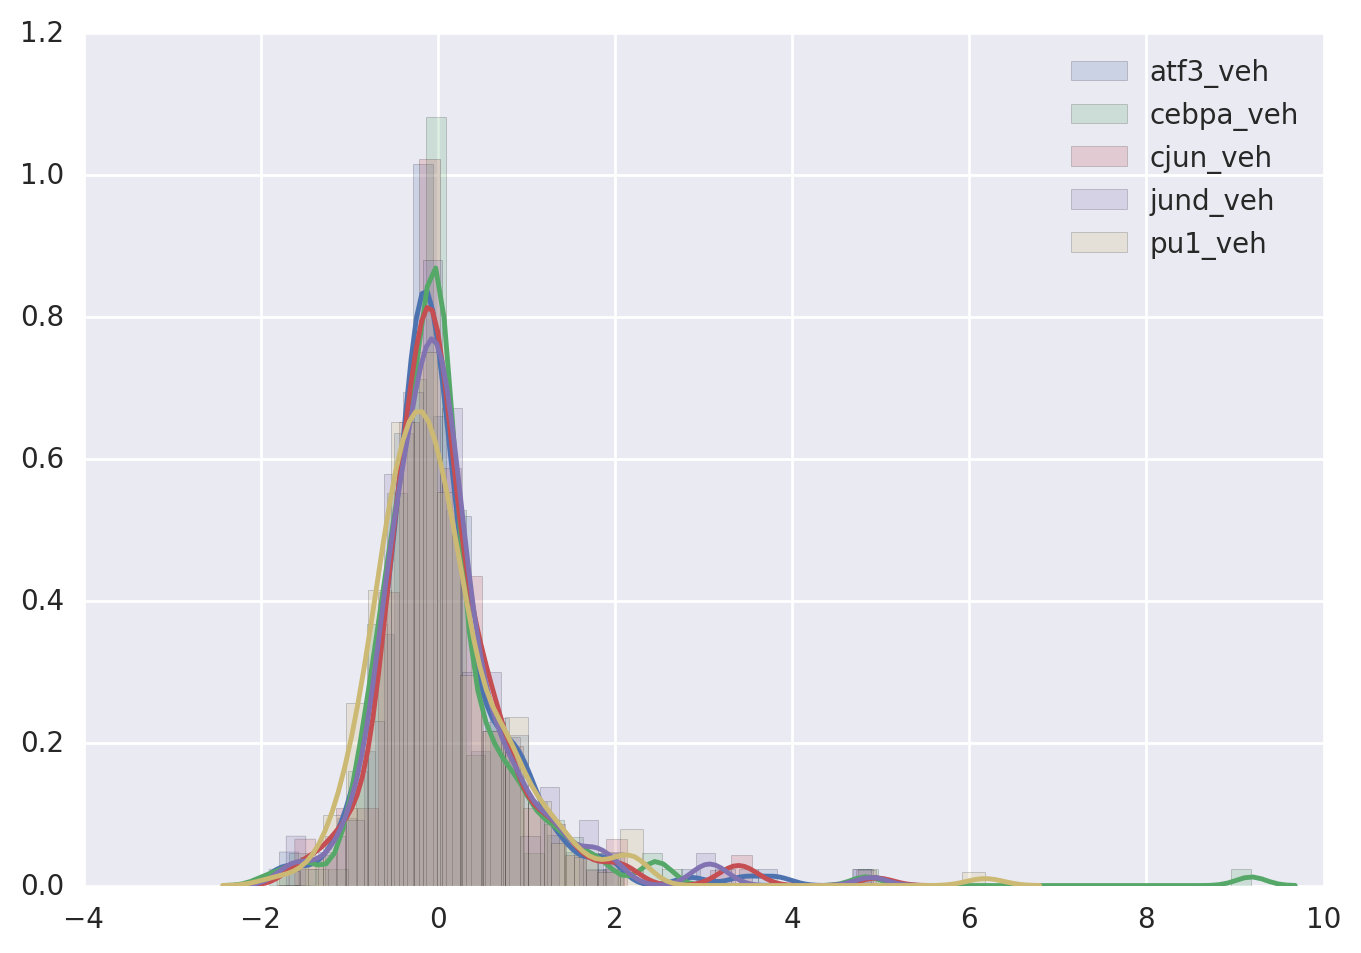

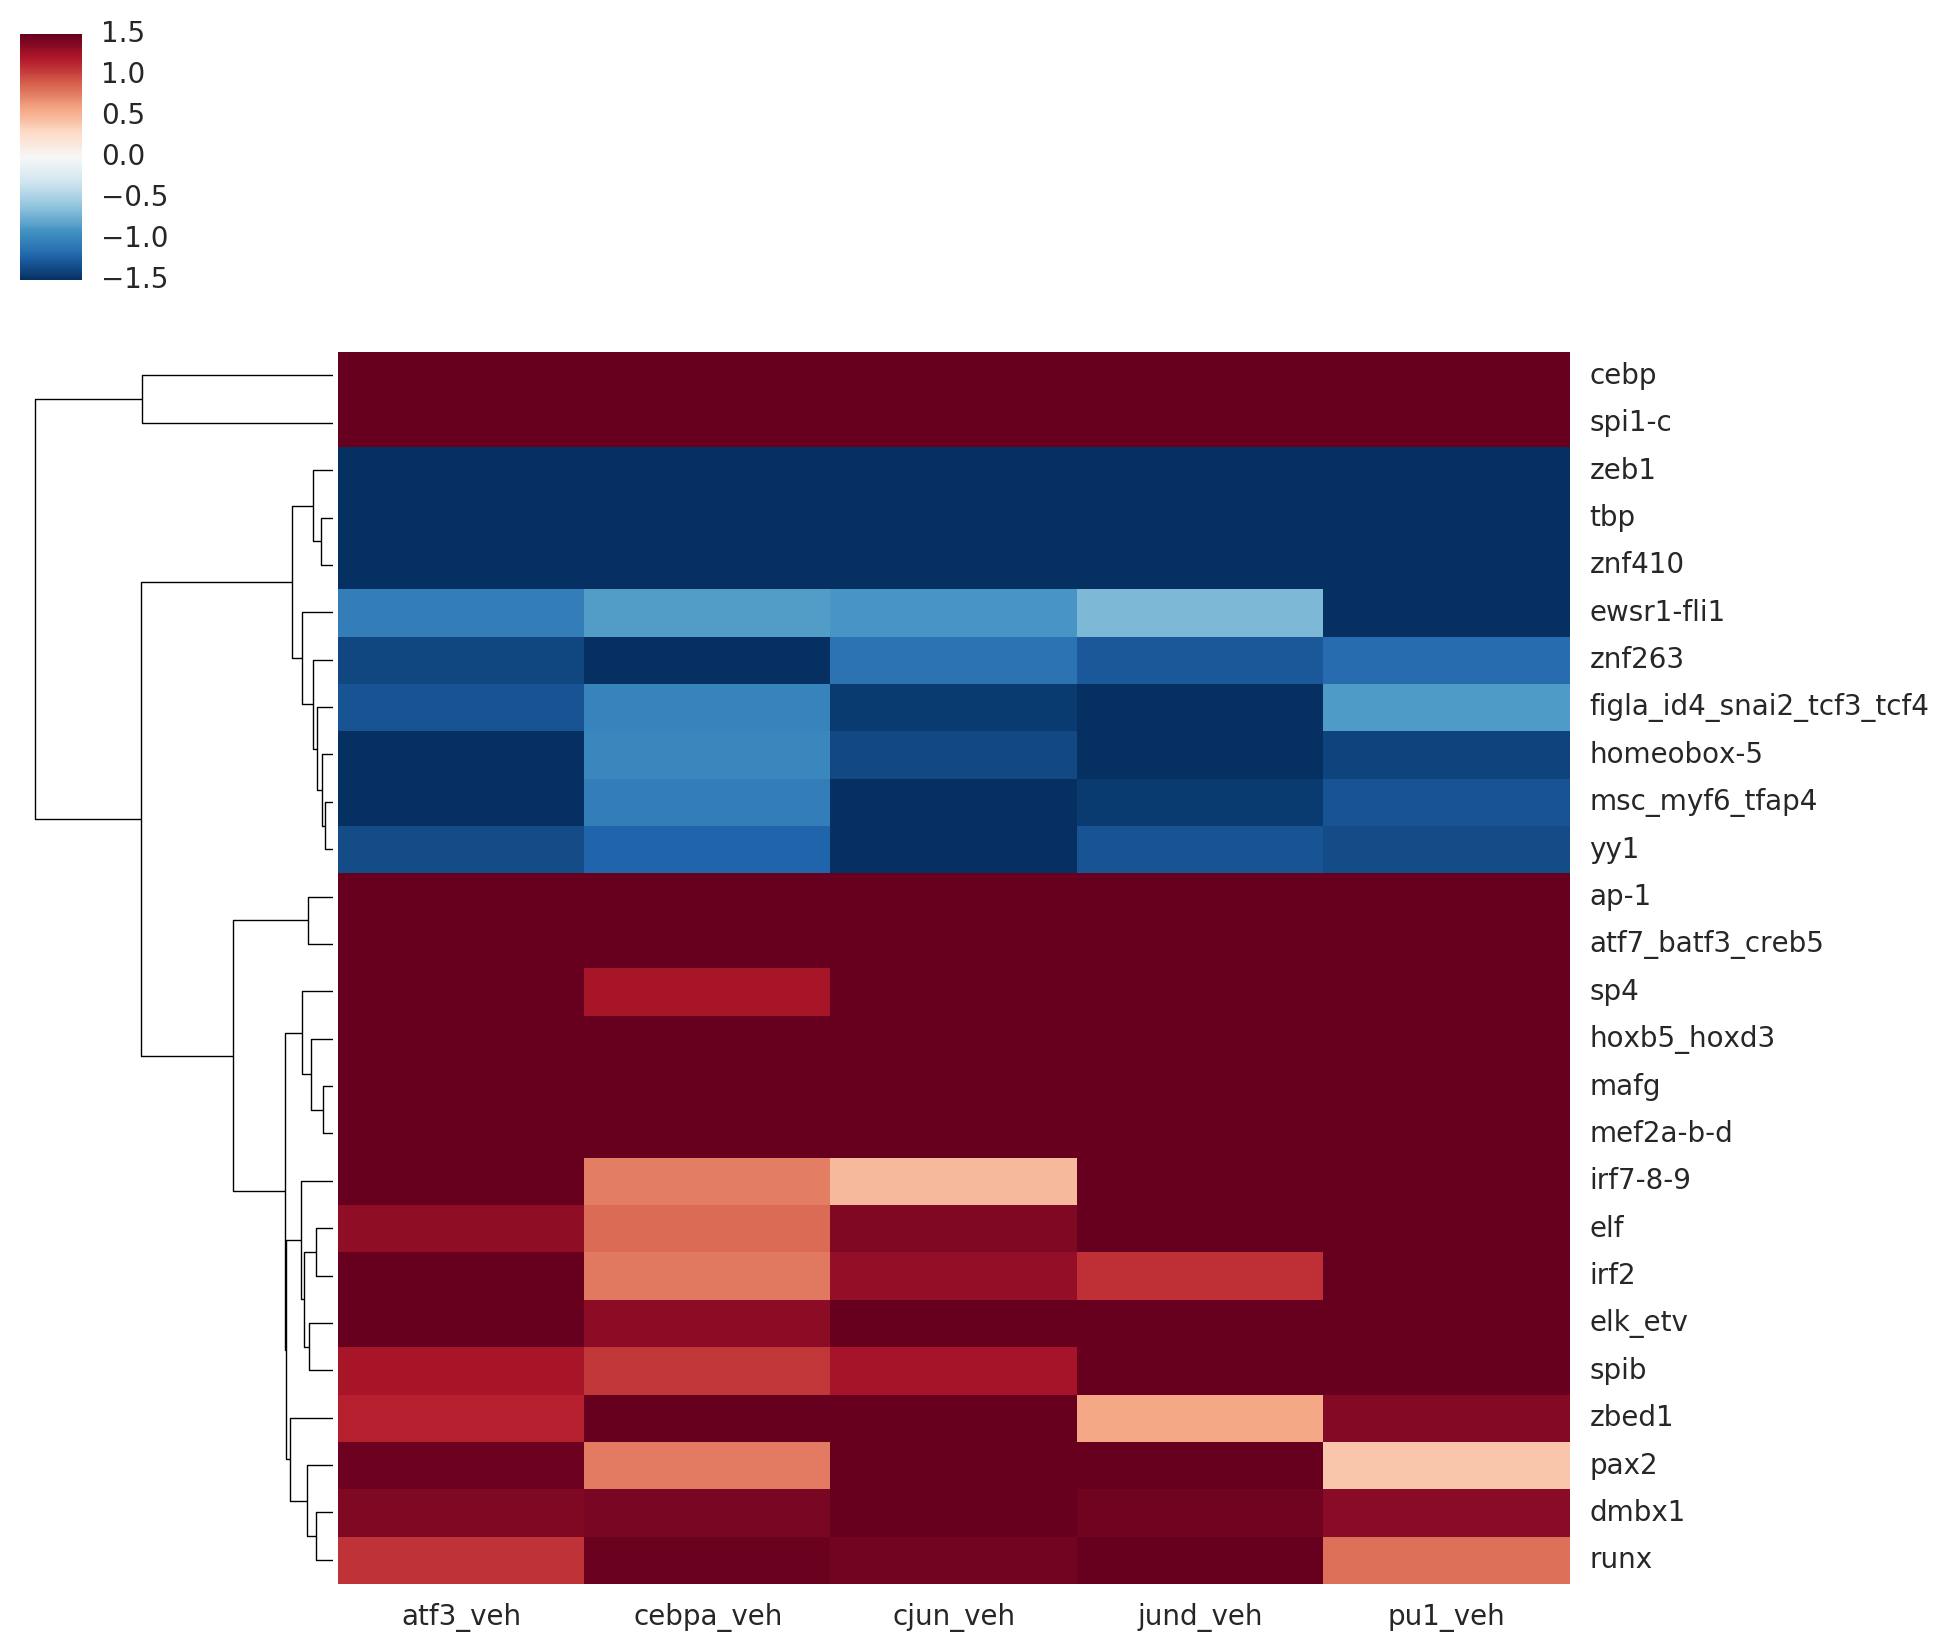

In [26]:
coefficients_affinity_frame = pd.DataFrame(factor_coeff_normed_affinity_dict)
coefficients_affinity_frame.index = standardized_motif_frame.columns.values
for col in coefficients_affinity_frame.columns.values:
    sns.distplot(coefficients_affinity_frame[col].values, label=col, hist_kws={'alpha':0.2})

plt.legend()

# transform_coffcients into z-scores
coefficients_zscore_affinity_frame = coefficients_affinity_frame[[]]
for col in coefficients_affinity_frame:
    coefficients_zscore_affinity_frame[col] = scipy.stats.mstats.zscore(coefficients_affinity_frame[col].values)

coefficients_zscore_affinity_frame.index = coefficients_affinity_frame.index.values
coefficients_zscore_affinity_frame.columns = coefficients_affinity_frame.columns.values

### plot coefficents for vehicle
weight_threshold = 1.5

for treatment in ['veh']:
    data = coefficients_zscore_affinity_frame
    data = data[[x for x in coefficients_zscore_affinity_frame.columns.values if treatment in x]]
    data = data[(data.max(axis=1) >= weight_threshold) |
                (data.min(axis=1) < -1 * weight_threshold)
                ]
    cg = sns.clustermap(data,
                       vmax=weight_threshold,
                       vmin=weight_threshold,
                       center = 0.0,
                       col_cluster = False,
                       xticklabels=[x.replace('c57bl6_','') for x in data.columns.values])
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0, );

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/seaborn-0.7.1-py3.5.egg/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:


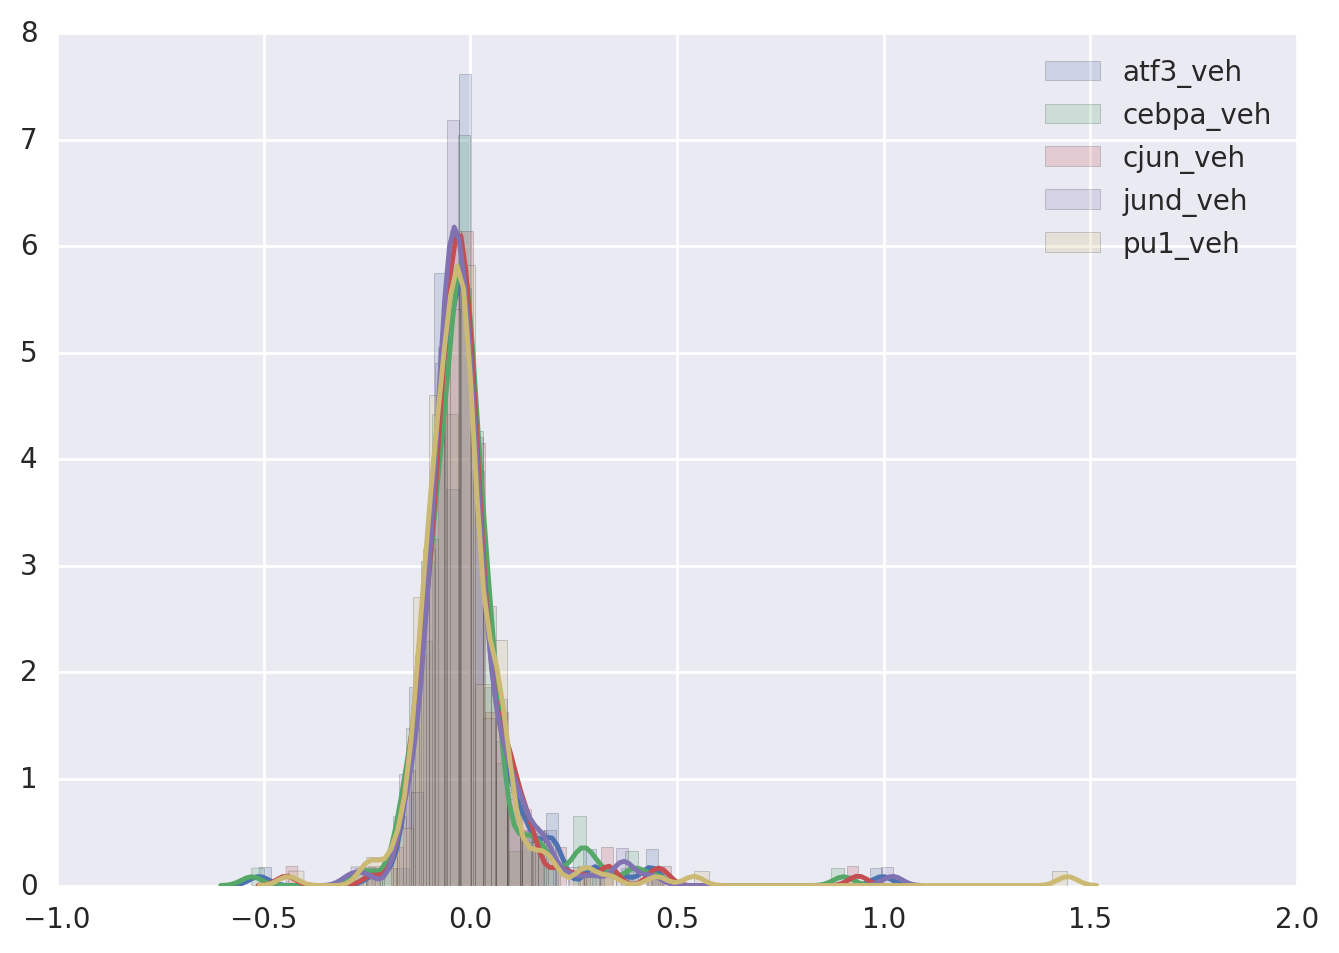

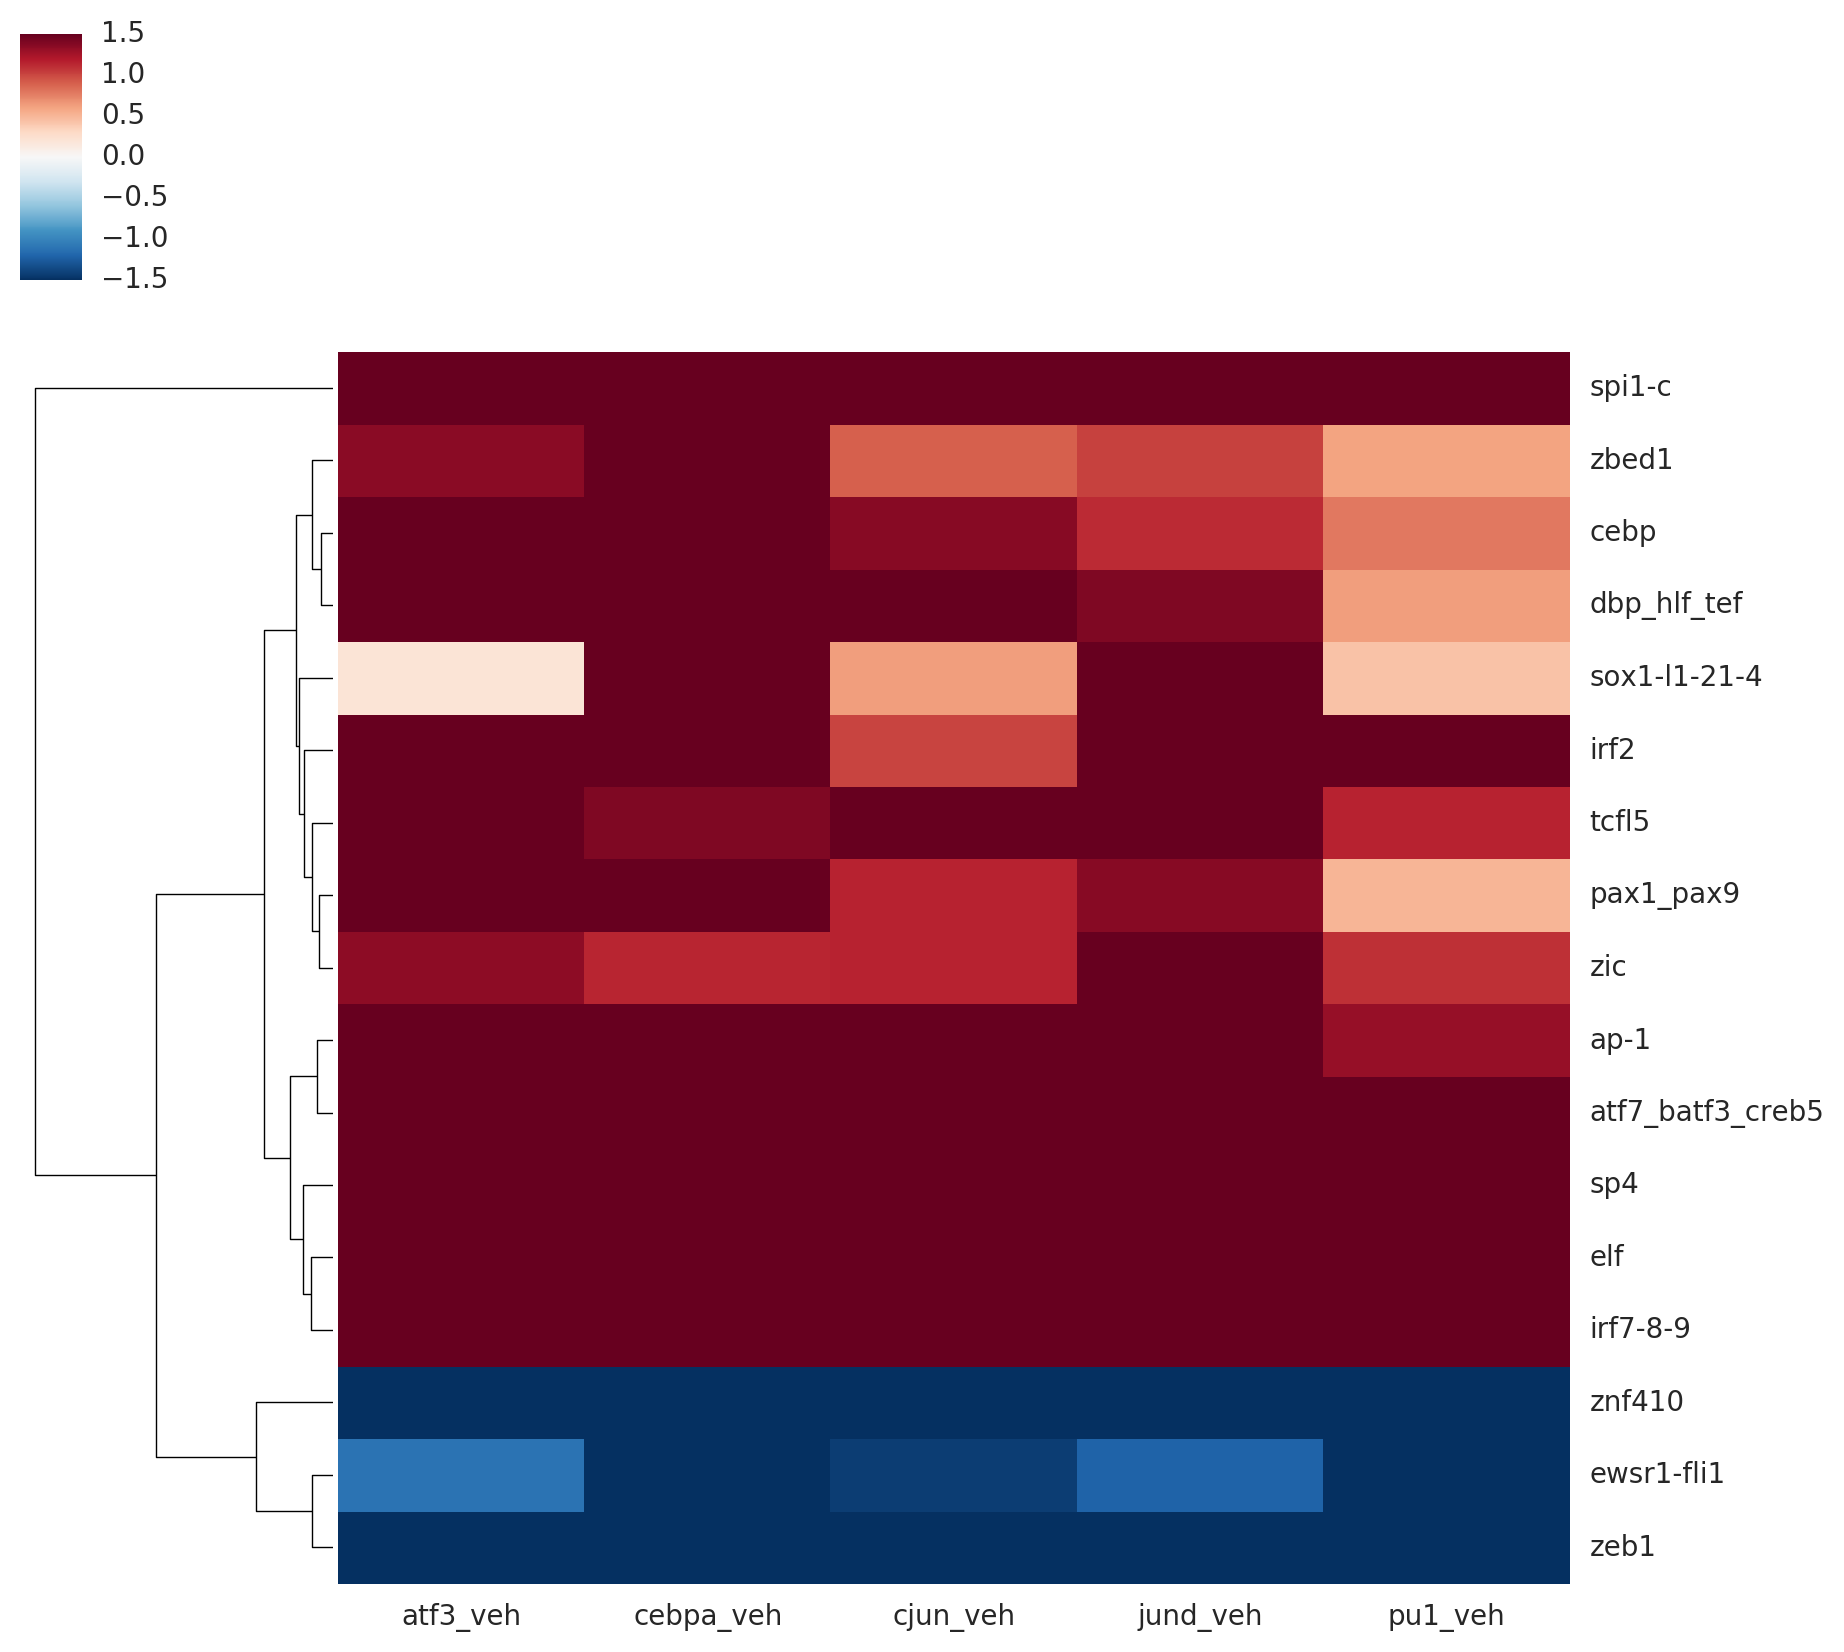

In [27]:
coefficients_counts_frame = pd.DataFrame(factor_coeff_normed_count_dict)
coefficients_counts_frame.index = standardized_motif_frame.columns.values
for col in coefficients_counts_frame.columns.values:
    sns.distplot(coefficients_counts_frame[col].values, label=col, hist_kws={'alpha':0.2})

plt.legend()

# transform_coffcients into z-scores
coefficients_zscore_counts_frame = coefficients_counts_frame[[]]
for col in coefficients_counts_frame:
    coefficients_zscore_counts_frame[col] = scipy.stats.mstats.zscore(coefficients_counts_frame[col].values)

coefficients_zscore_counts_frame.index = coefficients_counts_frame.index.values
coefficients_zscore_counts_frame.columns = coefficients_counts_frame.columns.values

### plot coefficents for vehicle
weight_threshold = 1.5

for treatment in ['veh']:
    data = coefficients_zscore_counts_frame
    data = data[[x for x in coefficients_zscore_counts_frame.columns.values if treatment in x]]
    data = data[(data.max(axis=1) >= weight_threshold) |
                (data.min(axis=1) < -1 * weight_threshold)
                ]
    cg = sns.clustermap(data,
                       vmax=weight_threshold,
                       vmin=weight_threshold,
                       center = 0.0,
                       col_cluster = False,
                       xticklabels=[x.replace('c57bl6_','') for x in data.columns.values])
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0, );

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/seaborn-0.7.1-py3.5.egg/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:


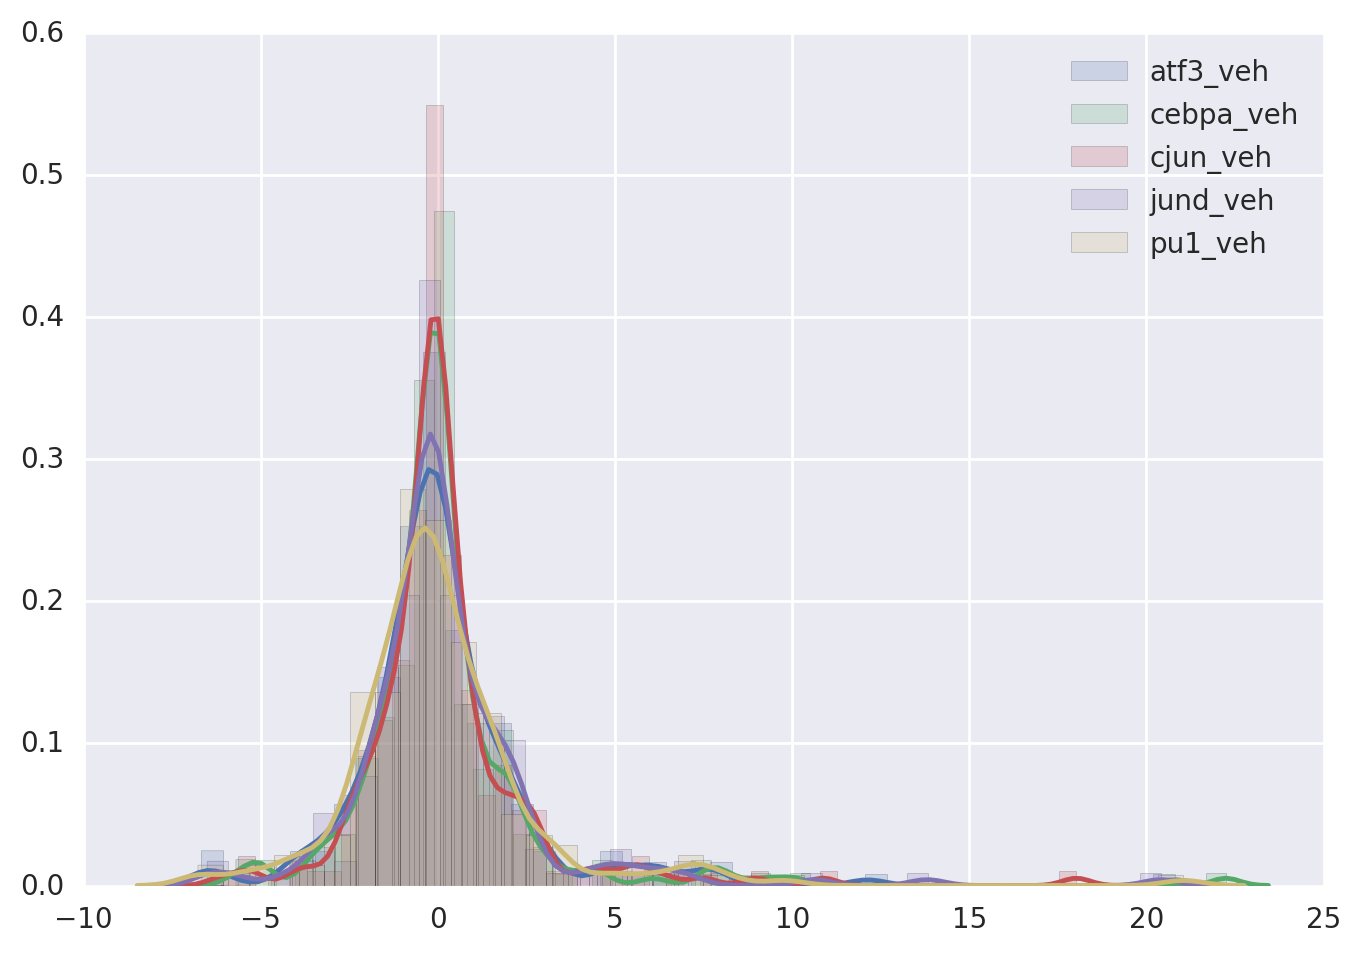

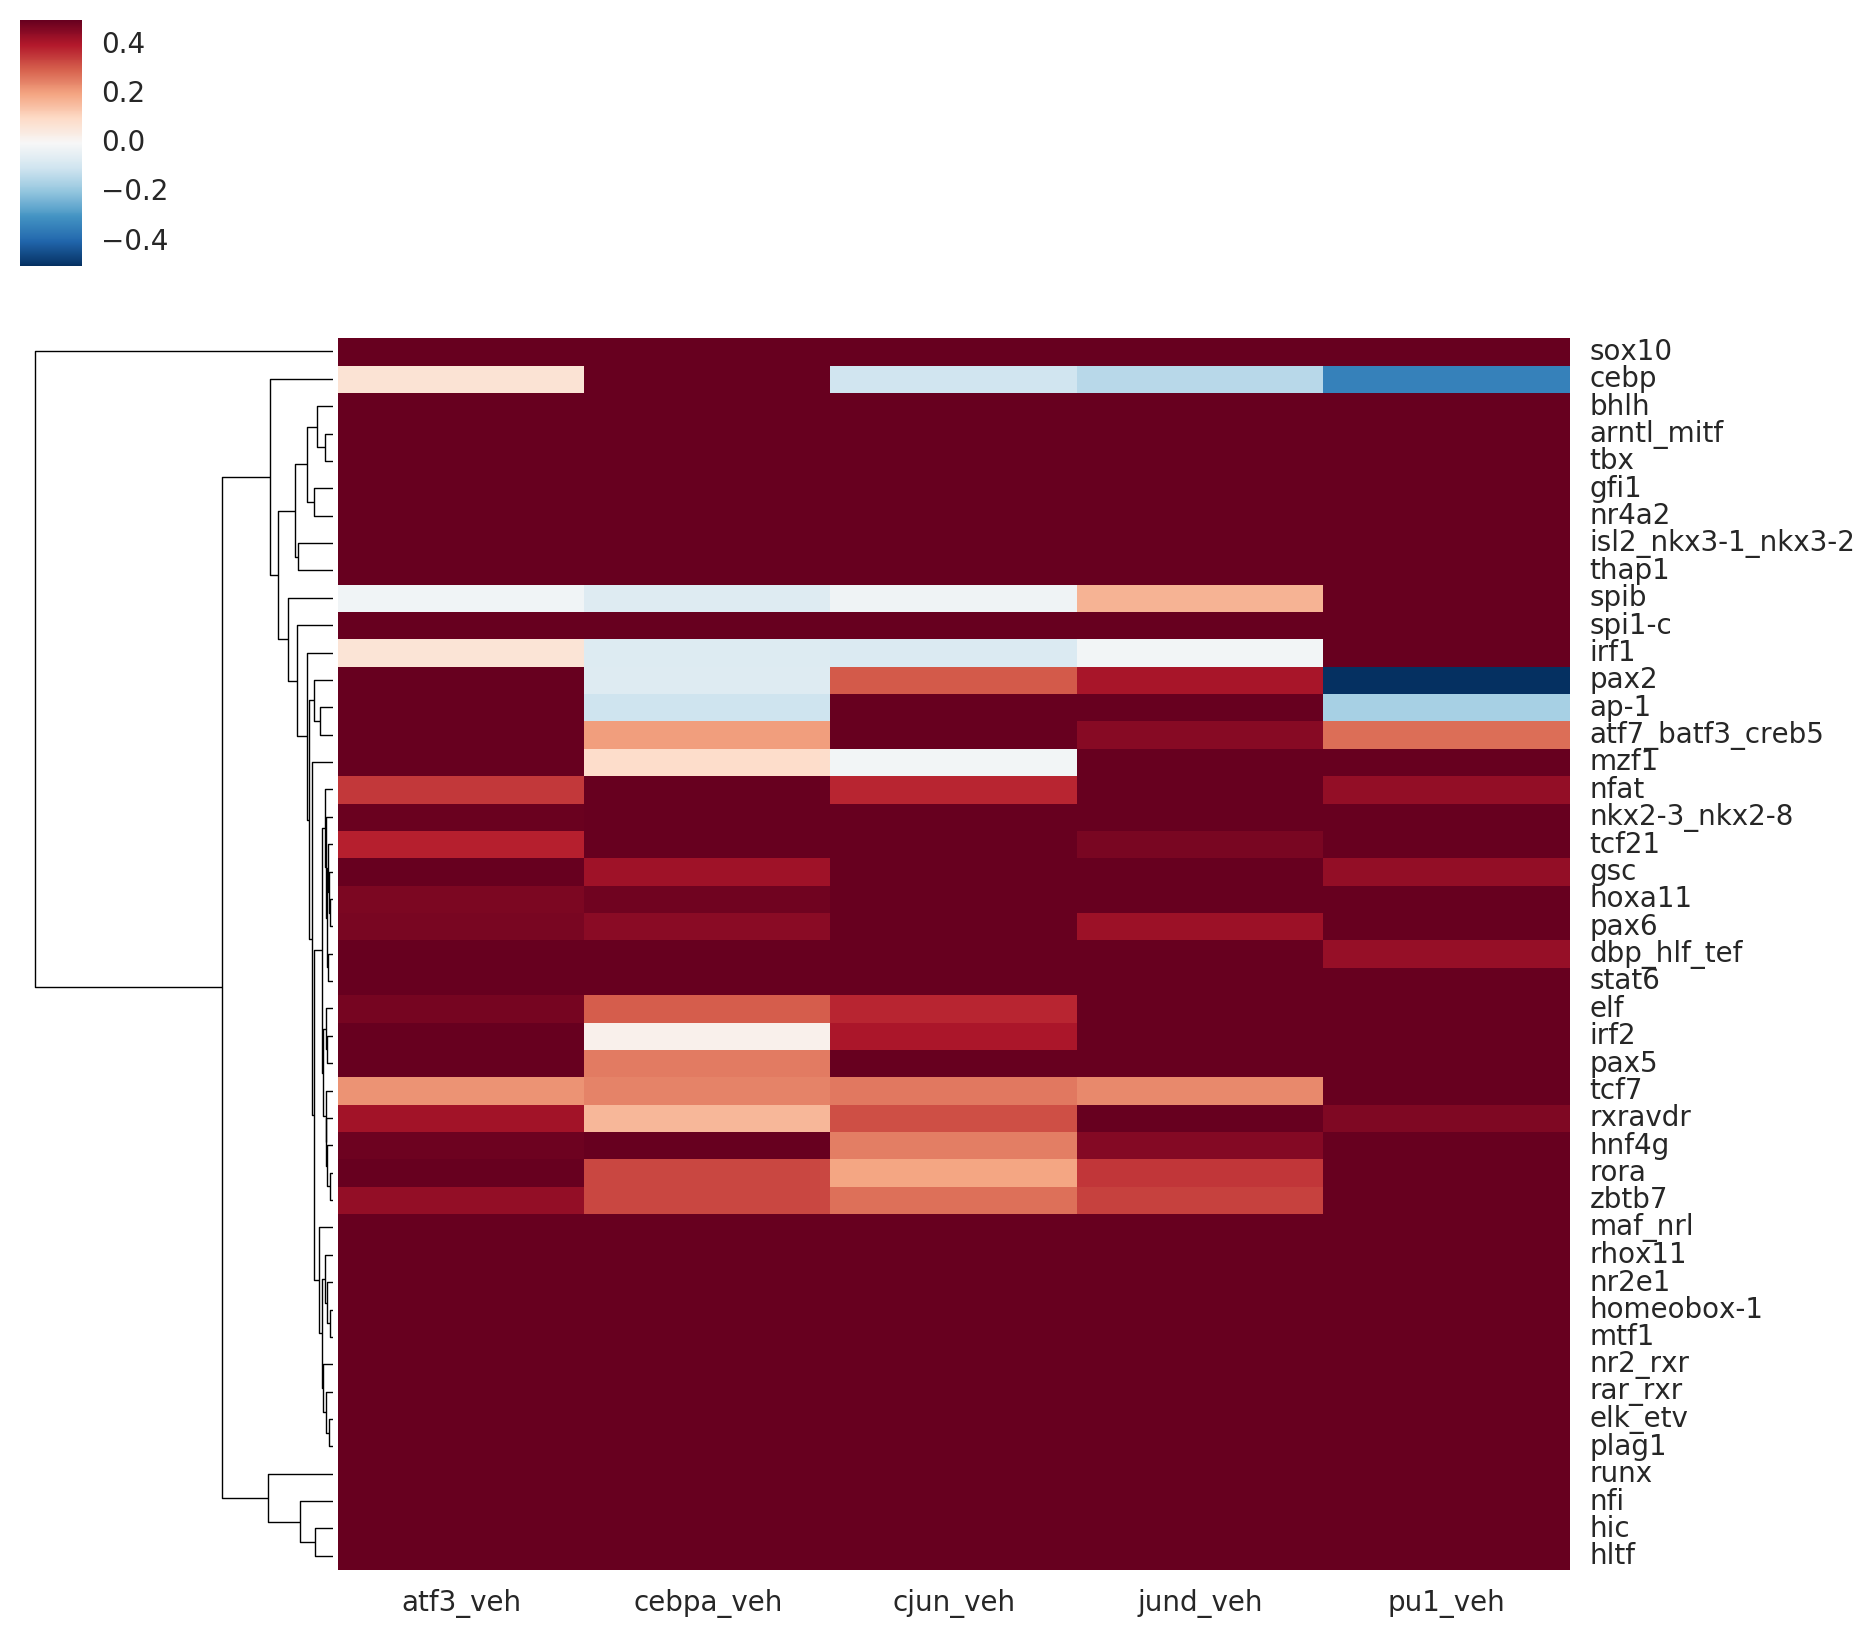

In [82]:
coefficients_summedScore_frame = pd.DataFrame(factor_coeff_normed_summedScore_dict)
coefficients_summedScore_frame.index = normed_summedScore_frame.columns.values
for col in coefficients_summedScore_frame.columns.values:
    sns.distplot(coefficients_summedScore_frame[col].values, label=col, hist_kws={'alpha':0.2})

plt.legend()

# transform_coffcients into z-scores
coefficients_zscore_summedScore_frame = coefficients_summedScore_frame[[]]
for col in coefficients_summedScore_frame:
    coefficients_zscore_summedScore_frame[col] = scipy.stats.mstats.zscore(coefficients_summedScore_frame[col].values)

coefficients_zscore_summedScore_frame.index = coefficients_summedScore_frame.index.values
coefficients_zscore_summedScore_frame.columns = coefficients_summedScore_frame.columns.values

weight_threshold = 0.5

for treatment in ['veh']:
    data = coefficients_zscore_summedScore_frame
    data = data[[x for x in coefficients_zscore_summedScore_frame.columns.values if treatment in x]]
#     data = data[(data.max(axis=1) >= weight_threshold) |
#                 (data.min(axis=1) < -1 * weight_threshold)
#                 ]
    data = data[(data.max(axis=1) >= weight_threshold)]
    cg = sns.clustermap(data,
                       vmax=weight_threshold,
                       vmin=weight_threshold,
                       center = 0.0,
                       col_cluster = False,
                       xticklabels=[x.replace('c57bl6_','') for x in data.columns.values])
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0, );

## Standardized

### Combined Classifier and Subcomponents

In [29]:
numIterations = 5
test_size = 0.5
background_ratio = 1.0
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    

In [98]:
auc_standardized_list = []
monomer_standardized_list = []
treatment_standardized_list = []
feature_standardized_list = []
# for monomers using all motifs
strain = 'c57bl6'
factor_coeff_standardized_affinity_dict = {}
factor_coeff_standardized_count_dict = {}
for treatment in ['veh']:
    for monomer in ['atf3', 'cjun', 'jund', 'pu1', 'cebpa']:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        target_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(target_indices)]
        background_indices = standardized_motif_background_frame.index.values 
        shuffle(background_indices)
        background_indices = background_indices[:background_ratio*len(target_indices)]
        background_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        affinity_features = pd.concat([target_features, background_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
        all_aucs = []
        all_count_aucs = []
        all_affinity_aucs = []
        all_coefficients = []
        all_count_coefficients = []
        all_affinity_coefficients = []
        all_precisions = []
        for i in range(numIterations):
            # split data into training and test sets
            training_affinity_features, test_affinity_features, training_labels, test_labels = get_split(
                affinity_features, labels, test_size = test_size)

            training_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(training_affinity_features.index.values)].ix[:,3:],
                                                 motif_count_background_frame[motif_count_background_frame.index.isin(training_affinity_features.index.values)].ix[:,3:]])
            test_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(test_affinity_features.index.values)].ix[:,3:],
                                             motif_count_background_frame[motif_count_background_frame.index.isin(test_affinity_features.index.values)].ix[:,3:]])
            #  Train affinity classifier
            affinity_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            affinity_classifier.fit(training_affinity_features, training_labels)

            # Train count classifier
            count_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            count_classifier.fit(training_count_features, training_labels)

            # train combined classifier
            training_affinity_scores = affinity_classifier.decision_function(training_affinity_features)
            training_count_scores = count_classifier.decision_function(training_count_features)
            training_combined_features = pd.DataFrame({'Affinity':training_affinity_scores,
                                             'Count':training_count_scores})
            scaler = preprocessing.StandardScaler()
            training_combined_standardized_features = pd.DataFrame(scaler.fit_transform(training_combined_features[['Affinity', 'Count']]))
            training_combined_standardized_features.index = training_combined_features.index.values
            training_combined_standardized_features.columns = training_combined_features.columns.values
            combined_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            combined_classifier.fit(training_combined_standardized_features, training_labels)
            print('affinity, count', combined_classifier.coef_.flatten())

            # retrieve test probabilities
            test_affinity_scores = affinity_classifier.decision_function(test_affinity_features)
            test_count_scores = count_classifier.decision_function(test_count_features)
            test_combined_features = pd.DataFrame({'Affinity':test_affinity_scores,
                                                       'Count':test_count_scores})
            scaler = preprocessing.StandardScaler()
            test_combined_standardized_features = pd.DataFrame(scaler.fit_transform(test_combined_features[['Affinity', 'Count']]))
            test_combined_standardized_features.index = test_combined_features.index.values
            test_combined_standardized_features.columns = test_combined_features.columns.values
            probas = combined_classifier.predict_proba(test_combined_features)
            affinity_probas = affinity_classifier.predict_proba(test_affinity_features)
            count_probas = count_classifier.predict_proba(test_count_features)
            
            # score predictions
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas[:, 1], average = None)
            affinity_roc_auc = sklearn.metrics.roc_auc_score(test_labels, affinity_probas[:, 1], average = None)
            count_roc_auc = sklearn.metrics.roc_auc_score(test_labels, count_probas[:, 1], average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)

            all_aucs.append(current_roc_auc)
            all_count_aucs.append(count_roc_auc)
            all_affinity_aucs.append(affinity_roc_auc)
            all_precisions.append(current_precision)
            
            affinity_coefficients = affinity_classifier.coef_.flatten()
            all_affinity_coefficients.append(affinity_coefficients)
            count_coefficients = count_classifier.coef_.flatten()
            all_count_coefficients.append(count_coefficients)
                
            auc_standardized_list = auc_standardized_list + [current_roc_auc, count_roc_auc, affinity_roc_auc]
            monomer_standardized_list = monomer_standardized_list + 3*[monomer]
            treatment_standardized_list = treatment_standardized_list + 3*[treatment]
            feature_standardized_list = feature_standardized_list + ['Both', 'Count', 'Affinity']
            
        mean_coefficients = np.mean(all_coefficients, axis=0)
        factor_coeff_standardized_affinity_dict[monomer + '_' + treatment] = np.mean(all_affinity_coefficients, axis = 0)
        factor_coeff_standardized_count_dict[monomer + '_' + treatment] = np.mean(all_count_coefficients, axis = 0)
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_aucs), np.mean(all_affinity_aucs), np.mean(all_count_aucs),
              'precision:', np.mean(all_precisions), np.var(all_precisions),  
             )
        

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


affinity, count [ 2.60457367  1.48612276]
affinity, count [ 2.63973166  1.47557697]
affinity, count [ 2.69180261  1.44577993]
affinity, count [ 2.6657243   1.43731316]
affinity, count [ 2.59749456  1.47586775]
atf3_veh roc: 0.947454313133 0.92703143769 0.864258470765 precision: 0.948182279856 2.79539697364e-06


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


affinity, count [ 2.81163332  1.4513982 ]
affinity, count [ 2.84071207  1.48112622]
affinity, count [ 2.89580044  1.42784077]
affinity, count [ 2.72565524  1.39887222]
affinity, count [ 2.79237332  1.47004792]
cjun_veh roc: 0.948716213531 0.930330097961 0.857117254349 precision: 0.950696084899 3.6262171903e-06
affinity, count [ 2.74183701  1.52428921]
affinity, count [ 2.75921355  1.48467927]
affinity, count [ 2.73832806  1.48763891]
affinity, count [ 2.61966784  1.53978132]
affinity, count [ 2.66891229  1.5608976 ]
jund_veh roc: 0.948189981214 0.928916783715 0.862943401666 precision: 0.950524524658 3.12245089181e-06
affinity, count [ 2.77829232  1.81540708]
affinity, count [ 2.79408818  1.80600034]
affinity, count [ 2.70621395  1.81000512]
affinity, count [ 2.79244192  1.81025575]
affinity, count [ 2.78817144  1.8374894 ]
pu1_veh roc: 0.961184976012 0.942540704119 0.911343892613 precision: 0.964357311218 3.79287803918e-07
affinity, count [ 3.23910844  1.63049912]
affinity, count [ 3.3

### Summed Scores

In [99]:
# for monomers using all motifs
strain = 'c57bl6'
factor_coeff_standardized_summedScore_dict = {}
for treatment in ['veh']:
    for monomer in ['atf3', 'cjun', 'jund', 'pu1', 'cebpa']:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        target_features = all_standardized_summedScore_frame[all_standardized_summedScore_frame.index.isin(target_indices)]
        background_indices = standardized_summedScore_background_frame.index.values     # select subset of background indices to use
        
        shuffle(background_indices)
        background_indices = background_indices[:background_ratio*len(target_indices)]
        background_features = all_standardized_summedScore_frame[all_standardized_summedScore_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        affinity_features = pd.concat([target_features, background_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
        all_aucs = []
        all_coefficients = []
        all_precisions = []
        for i in range(numIterations):

            # split data into training and test sets
            training_affinity_features, test_affinity_features, training_labels, test_labels = get_split(
                affinity_features, labels, test_size = test_size)
            #  Train affinity classifier
            affinity_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            affinity_classifier.fit(training_affinity_features, training_labels)

            probas = affinity_classifier.predict_proba(test_affinity_features)
            # score predictions
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas[:, 1], average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)

            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)
            current_coefficients = affinity_classifier.coef_.flatten()
            all_coefficients.append(current_coefficients)
            
            auc_standardized_list.append(current_roc_auc)
            monomer_standardized_list.append(monomer)
            treatment_standardized_list.append(treatment)
            feature_standardized_list.append('Summed Affinity')
                
        mean_coefficients = np.mean(all_coefficients, axis=0)
        factor_coeff_standardized_summedScore_dict[monomer + '_' + treatment] = mean_coefficients
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_aucs), np.var(all_aucs),
              'precision:', np.mean(all_precisions), np.var(all_precisions),  
              'numTestPositives:', np.sum(test_labels)
             )
        

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


atf3_veh roc: 0.932887476491 6.66751679154e-07 precision: 0.927496483742 1.65108609051e-06 numTestPositives: 11073
cjun_veh roc: 0.928385970094 1.64867580514e-06 precision: 0.92268417269 1.30316322062e-06 numTestPositives: 6363
jund_veh roc: 0.930168355105 2.07365401537e-06 precision: 0.925981306625 2.68825195673e-06 numTestPositives: 9071
pu1_veh roc: 0.95166386754 7.28135627089e-07 precision: 0.950795098734 4.33494998301e-07 numTestPositives: 20067
cebpa_veh roc: 0.952239967497 1.81434119494e-06 precision: 0.949708935064 4.19490940581e-06 numTestPositives: 5876


(0.5, 1)

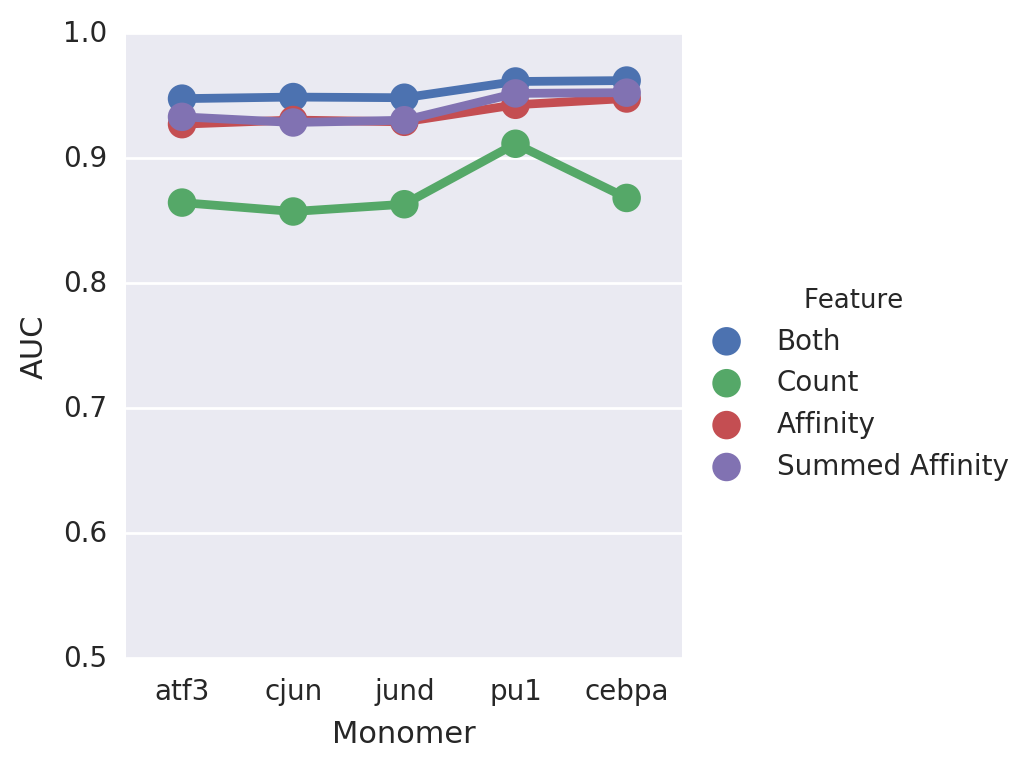

In [104]:
performance_frame = pd.DataFrame({'AUC':auc_standardized_list,
                                  'Monomer':monomer_standardized_list,
                                  'Treatment':treatment_standardized_list,
                                  'Feature':feature_standardized_list})
sns.factorplot(data=performance_frame, 
               x='Monomer', 
               y= 'AUC', 
#                col='Treatment', 
               hue='Feature')
plt.ylim(0.5,1)

### Visualize Coefficients

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/seaborn-0.7.1-py3.5.egg/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:


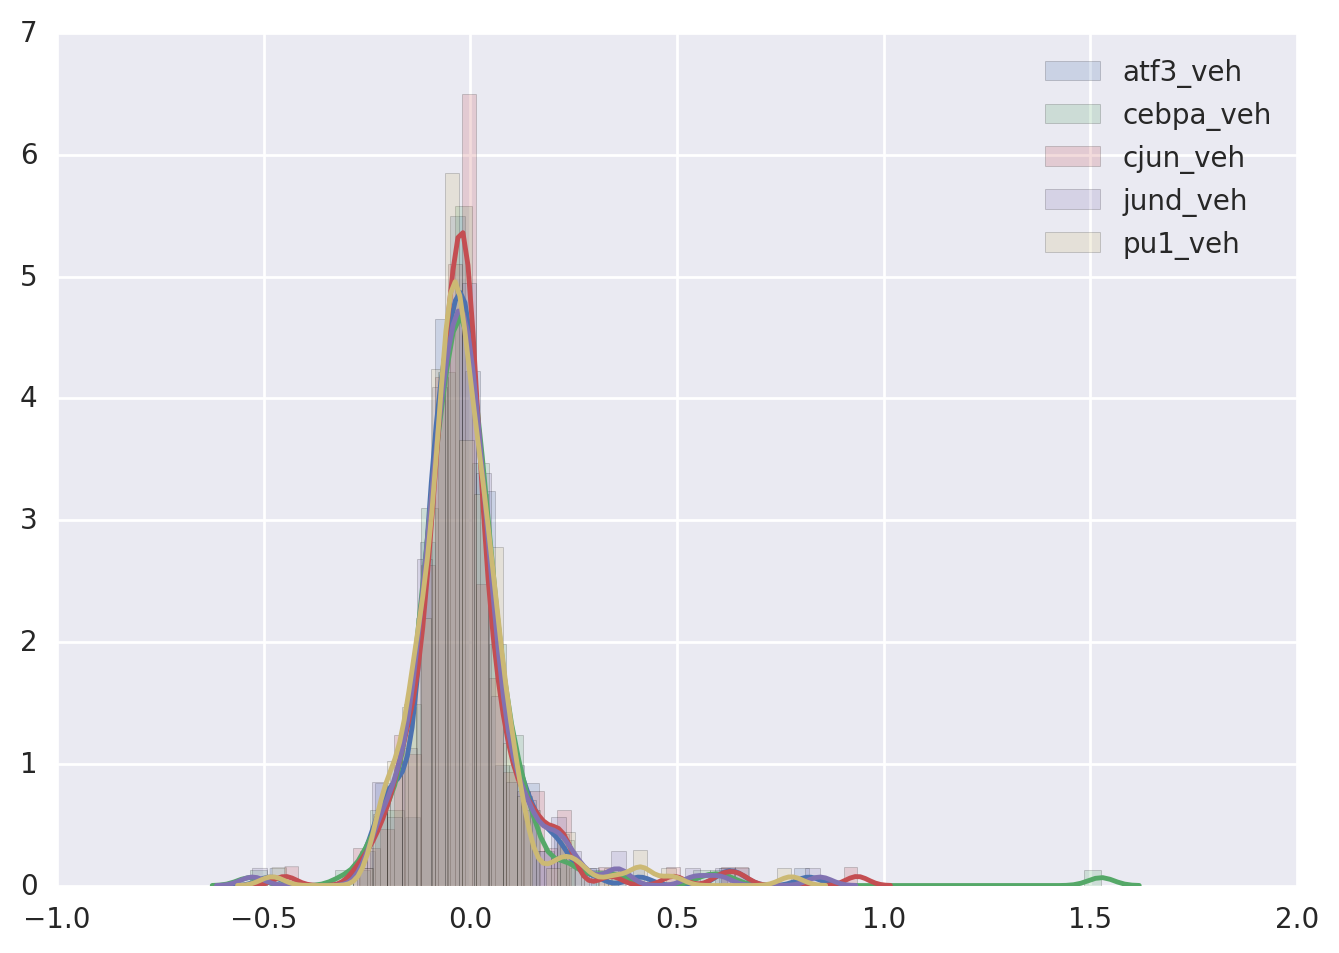

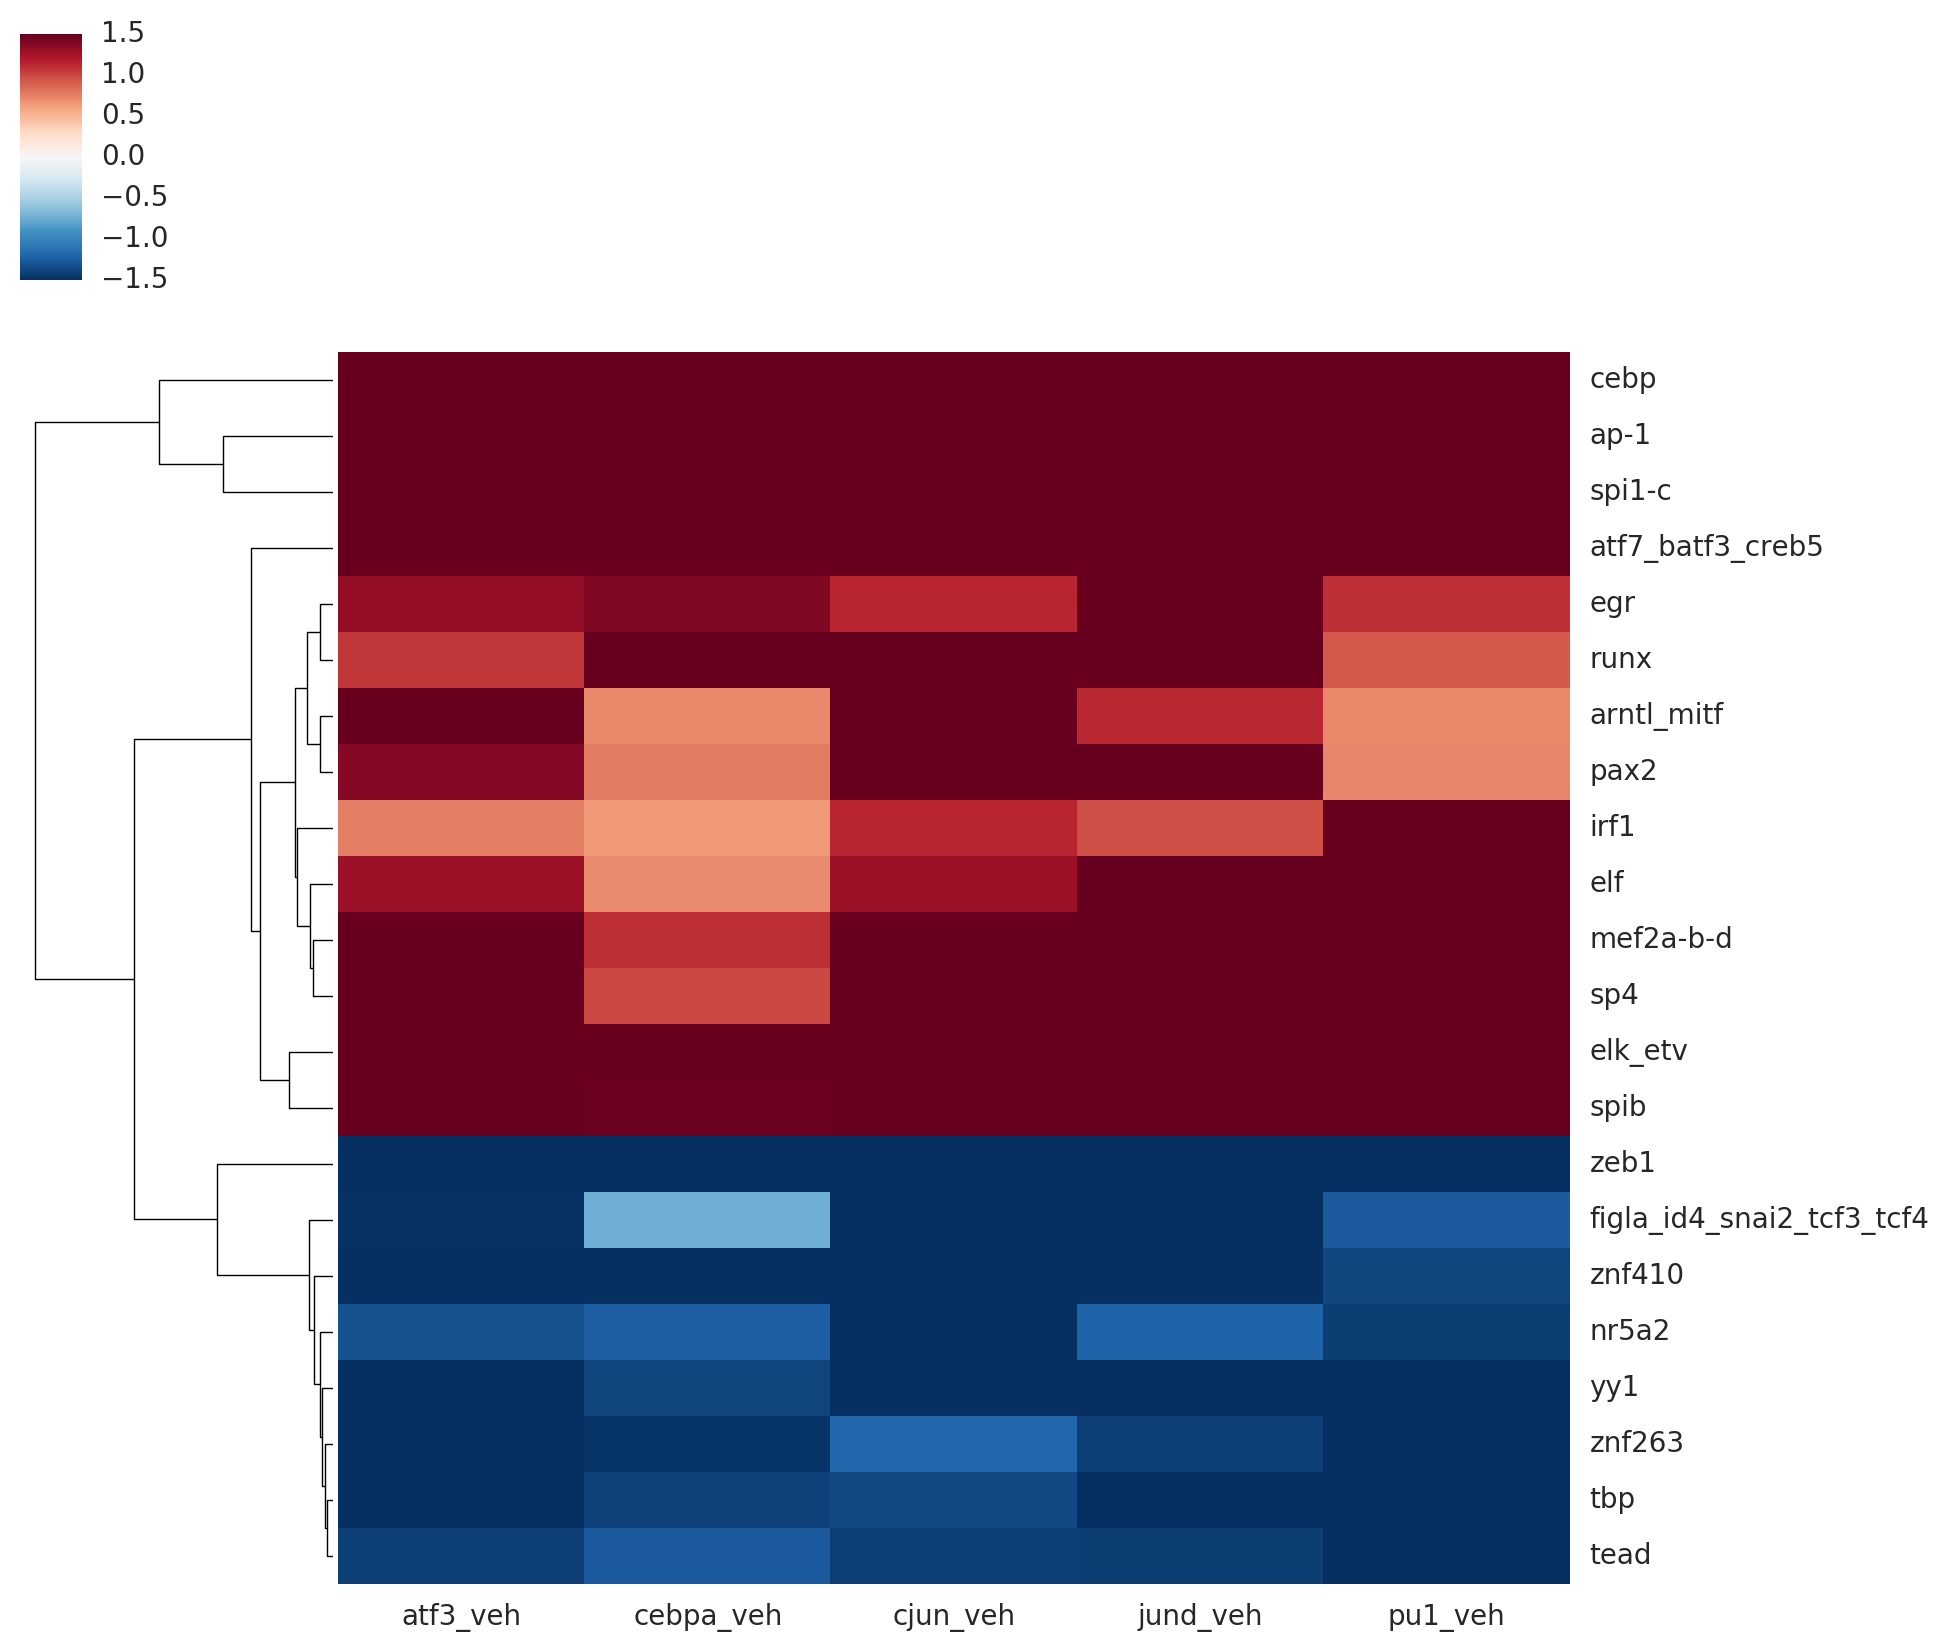

In [105]:
coefficients_affinity_frame = pd.DataFrame(factor_coeff_standardized_affinity_dict)
coefficients_affinity_frame.index = standardized_motif_frame.columns.values
for col in coefficients_affinity_frame.columns.values:
    sns.distplot(coefficients_affinity_frame[col].values, label=col, hist_kws={'alpha':0.2})

plt.legend()

# transform_coffcients into z-scores
coefficients_zscore_affinity_frame = coefficients_affinity_frame[[]]
for col in coefficients_affinity_frame:
    coefficients_zscore_affinity_frame[col] = scipy.stats.mstats.zscore(coefficients_affinity_frame[col].values)

coefficients_zscore_affinity_frame.index = coefficients_affinity_frame.index.values
coefficients_zscore_affinity_frame.columns = coefficients_affinity_frame.columns.values

### plot coefficents for vehicle
weight_threshold = 1.5

for treatment in ['veh']:
    data = coefficients_zscore_affinity_frame
    data = data[[x for x in coefficients_zscore_affinity_frame.columns.values if treatment in x]]
    data = data[(data.max(axis=1) >= weight_threshold) |
                (data.min(axis=1) < -1 * weight_threshold)
                ]
    cg = sns.clustermap(data,
                       vmax=weight_threshold,
                       vmin=weight_threshold,
                       center = 0.0,
                       col_cluster = False,
                       xticklabels=[x.replace('c57bl6_','') for x in data.columns.values])
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0, );

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/seaborn-0.7.1-py3.5.egg/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:


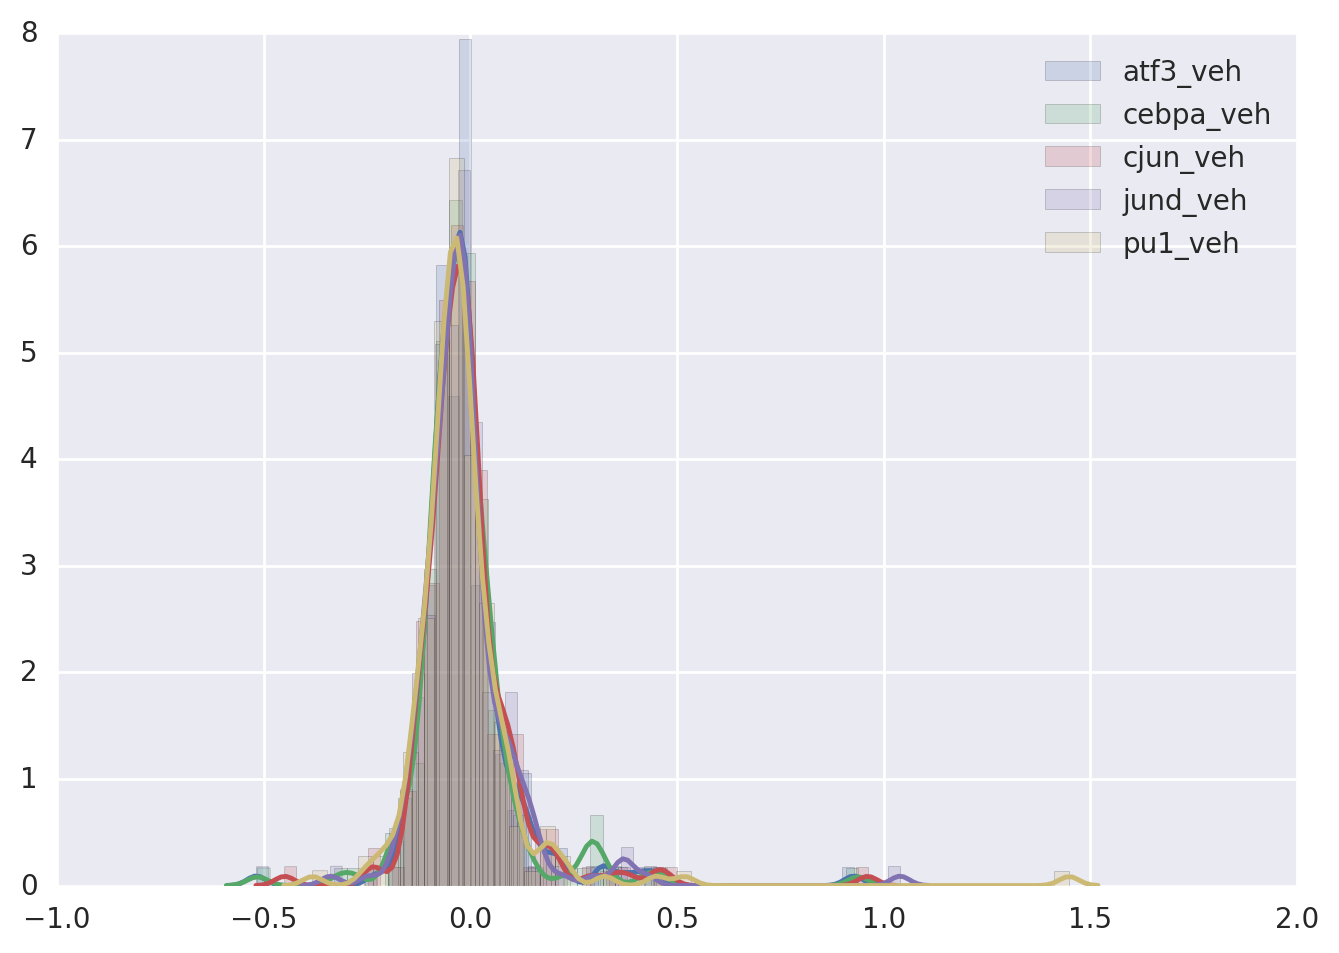

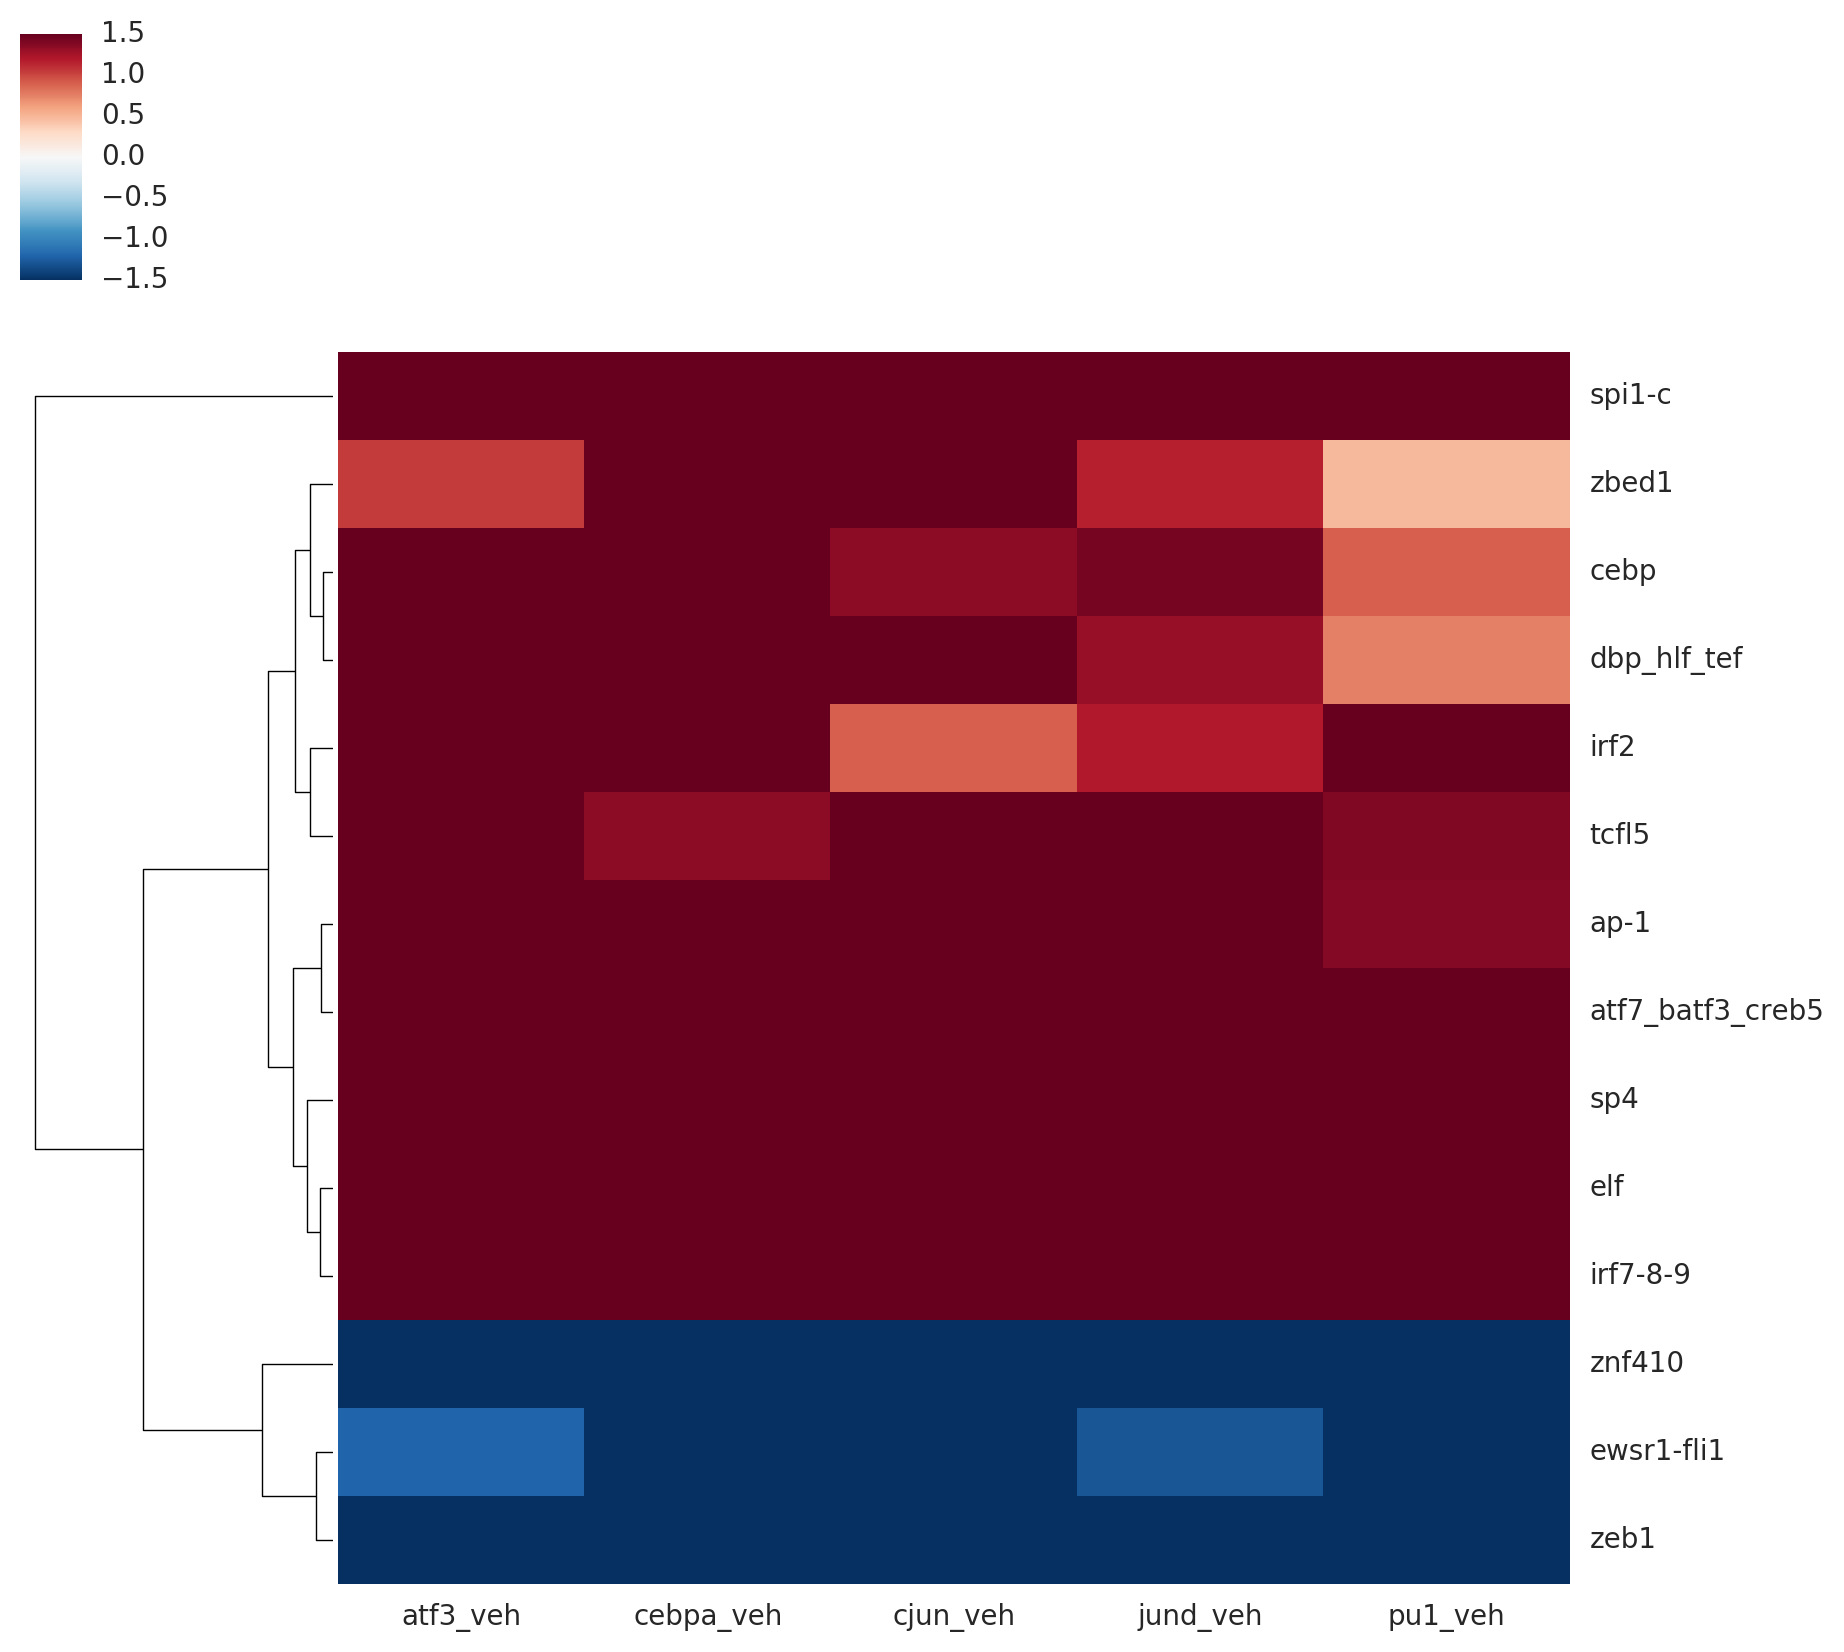

In [106]:
coefficients_counts_frame = pd.DataFrame(factor_coeff_standardized_count_dict)
coefficients_counts_frame.index = standardized_motif_frame.columns.values
for col in coefficients_counts_frame.columns.values:
    sns.distplot(coefficients_counts_frame[col].values, label=col, hist_kws={'alpha':0.2})

plt.legend()

# transform_coffcients into z-scores
coefficients_zscore_counts_frame = coefficients_counts_frame[[]]
for col in coefficients_counts_frame:
    coefficients_zscore_counts_frame[col] = scipy.stats.mstats.zscore(coefficients_counts_frame[col].values)

coefficients_zscore_counts_frame.index = coefficients_counts_frame.index.values
coefficients_zscore_counts_frame.columns = coefficients_counts_frame.columns.values

weight_threshold = 1.5

for treatment in ['veh']:
    data = coefficients_zscore_counts_frame
    data = data[[x for x in coefficients_zscore_counts_frame.columns.values if treatment in x]]
    data = data[(data.max(axis=1) >= weight_threshold) |
                (data.min(axis=1) < -1 * weight_threshold)
                ]
    cg = sns.clustermap(data,
                       vmax=weight_threshold,
                       vmin=weight_threshold,
                       center = 0.0,
                       col_cluster = False,
                       xticklabels=[x.replace('c57bl6_','') for x in data.columns.values])
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0, );

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/seaborn-0.7.1-py3.5.egg/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:


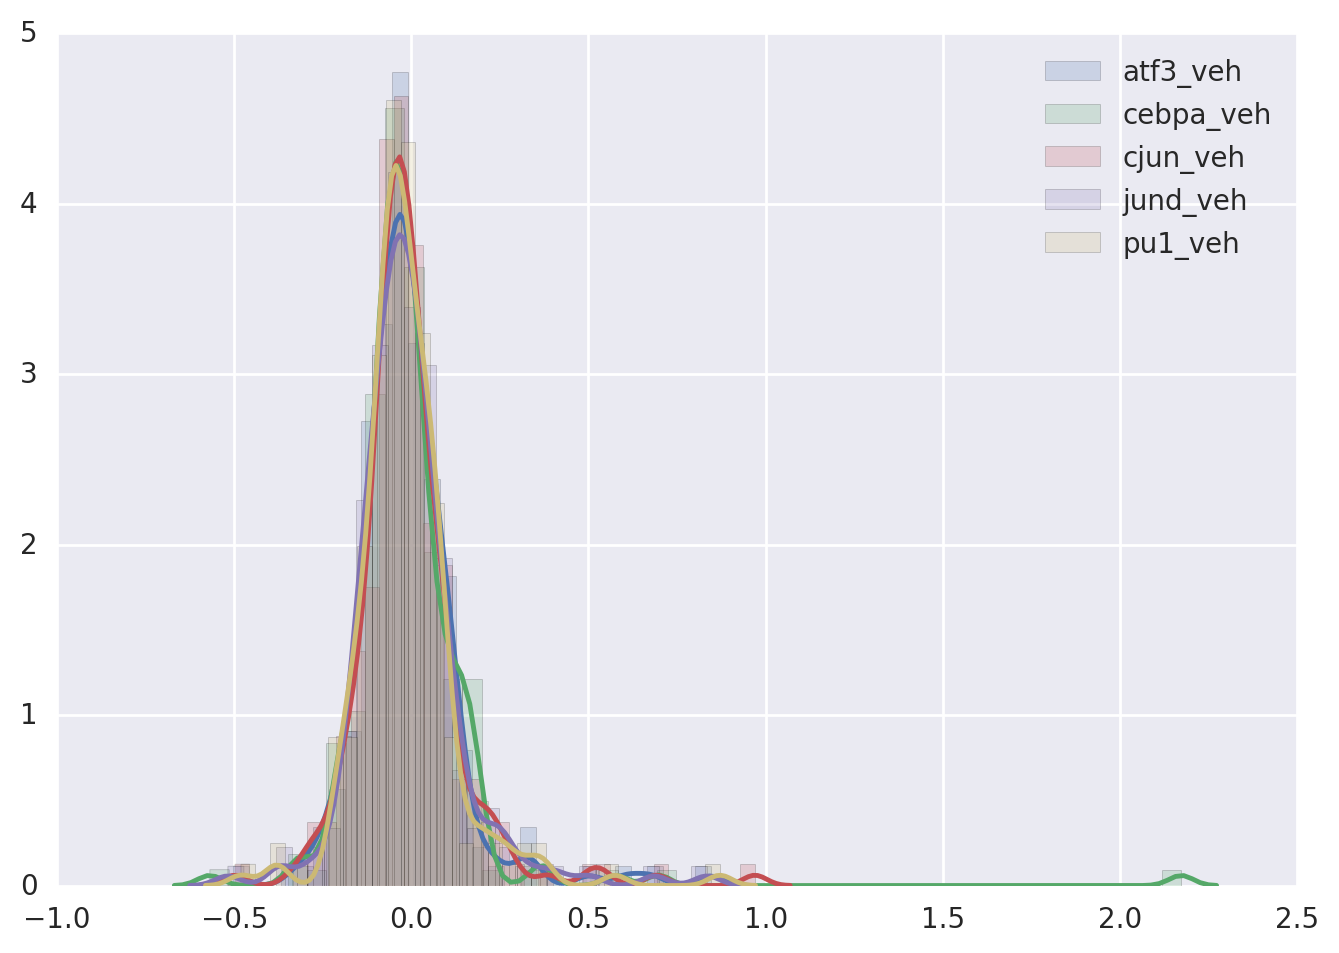

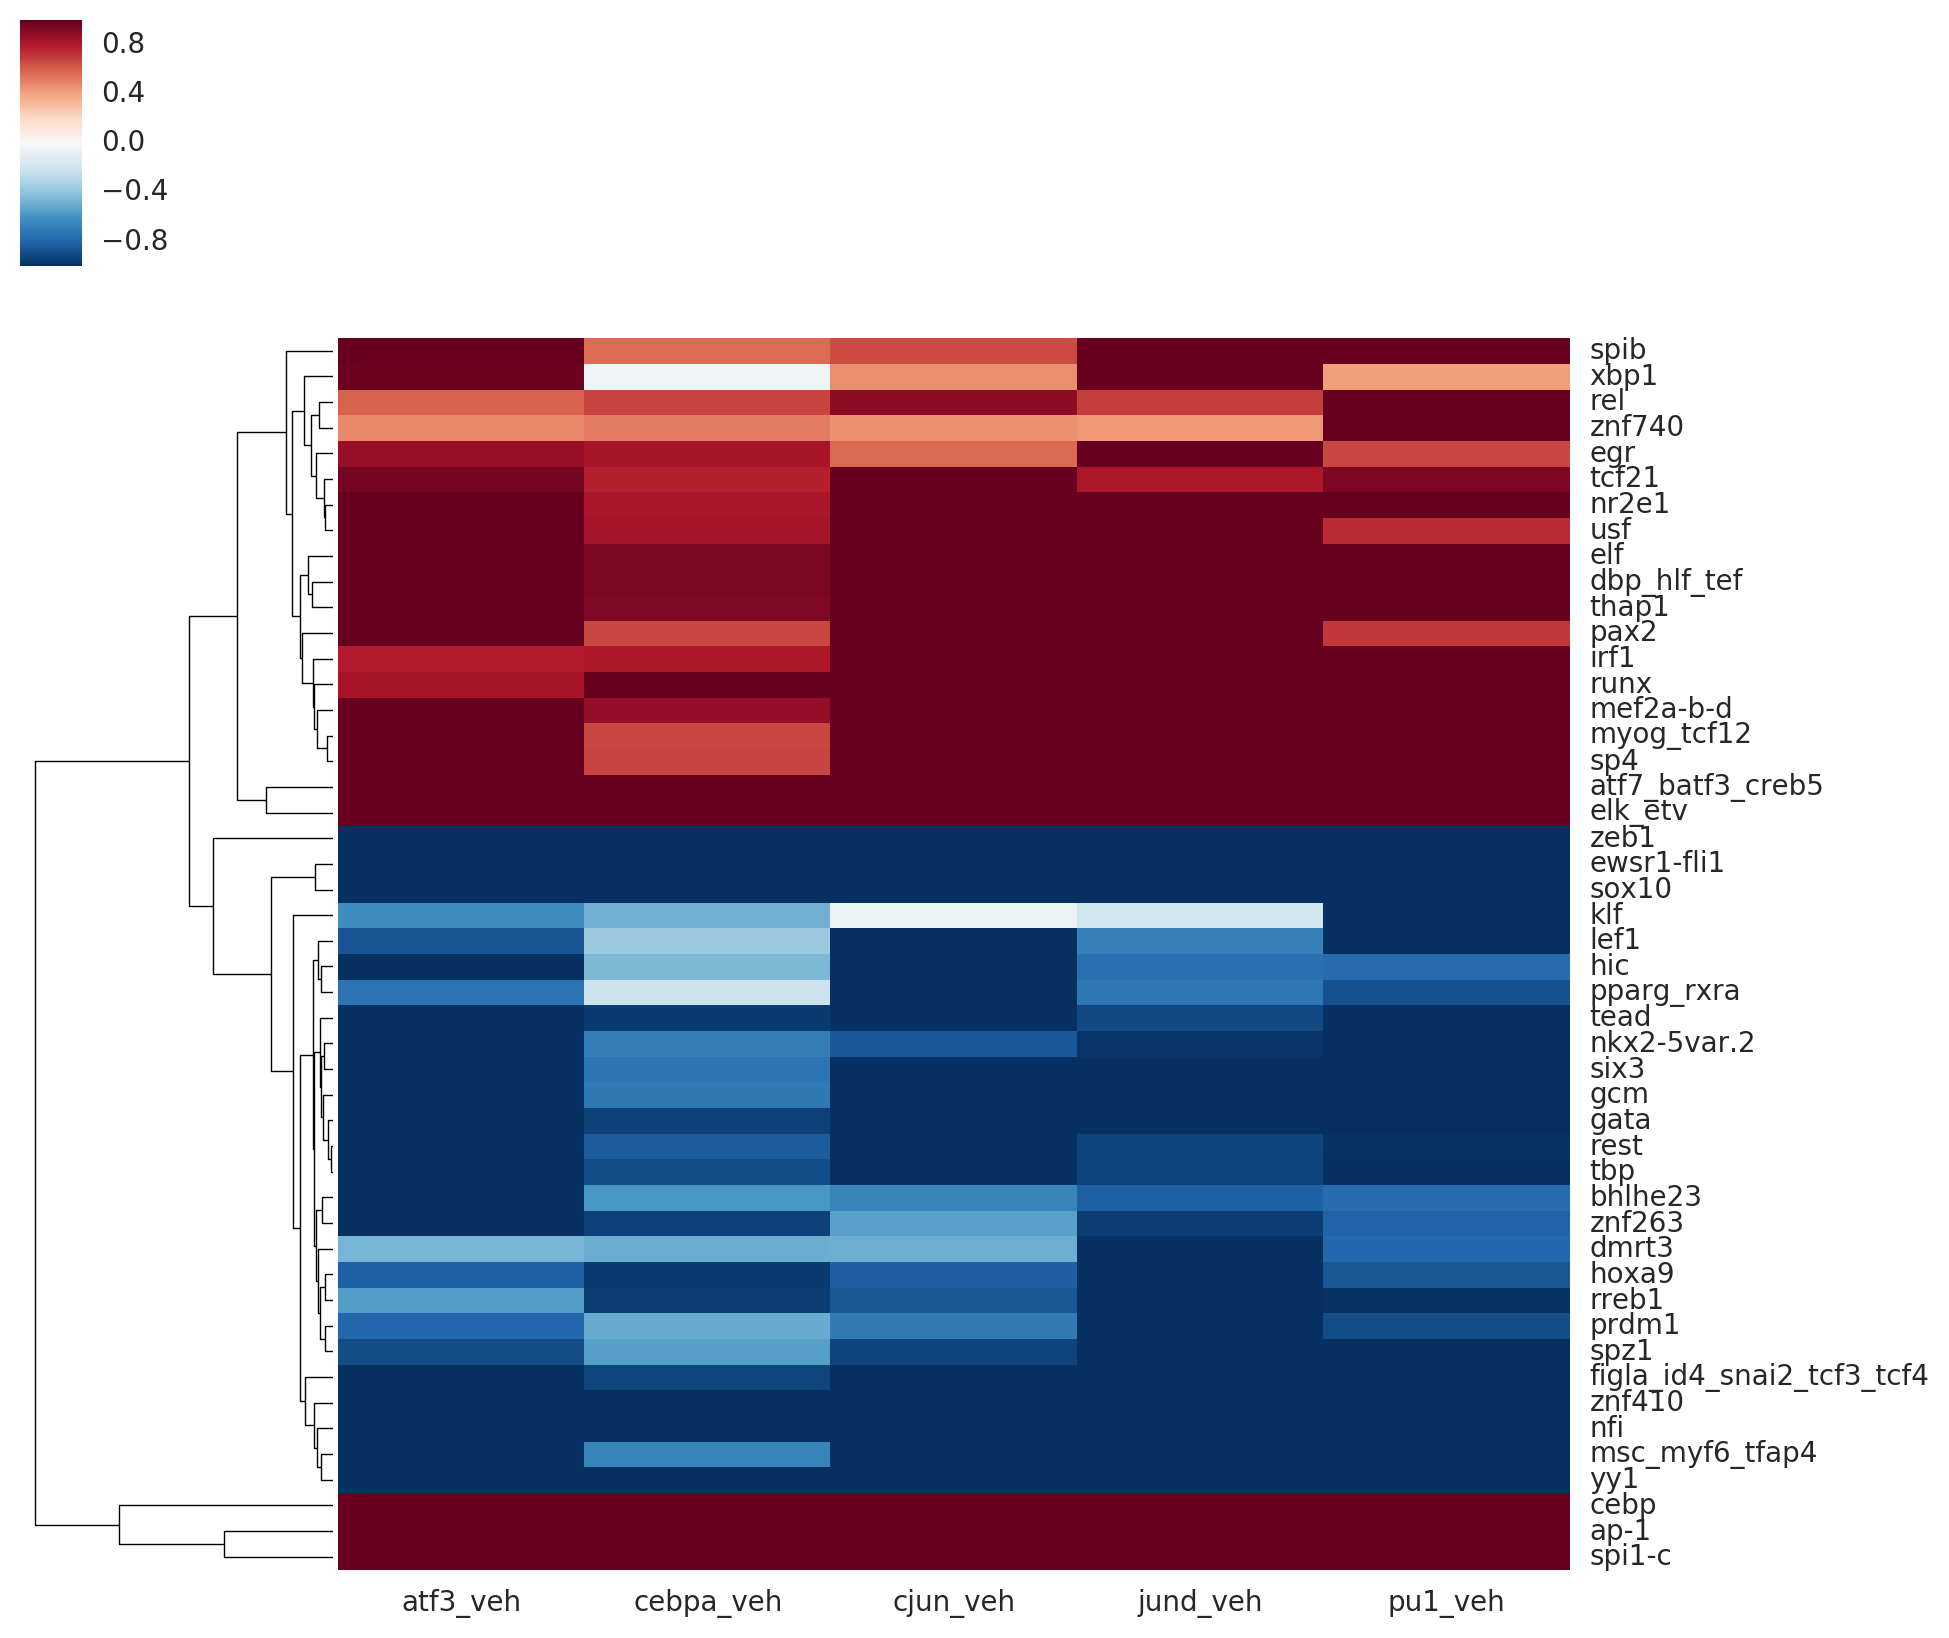

In [107]:
coefficients_summedScore_frame = pd.DataFrame(factor_coeff_standardized_summedScore_dict)
coefficients_summedScore_frame.index = standardized_summedScore_frame.columns.values
for col in coefficients_summedScore_frame.columns.values:
    sns.distplot(coefficients_summedScore_frame[col].values, label=col, hist_kws={'alpha':0.2})

plt.legend()

# transform_coffcients into z-scores
coefficients_zscore_summedScore_frame = coefficients_summedScore_frame[[]]
for col in coefficients_summedScore_frame:
    coefficients_zscore_summedScore_frame[col] = scipy.stats.mstats.zscore(coefficients_summedScore_frame[col].values)

coefficients_zscore_summedScore_frame.index = coefficients_summedScore_frame.index.values
coefficients_zscore_summedScore_frame.columns = coefficients_summedScore_frame.columns.values

weight_threshold = 1.0

for treatment in ['veh']:
    data = coefficients_zscore_summedScore_frame
    data = data[[x for x in coefficients_zscore_summedScore_frame.columns.values if treatment in x]]
    data = data[(data.max(axis=1) >= weight_threshold) |
                (data.min(axis=1) < -1 * weight_threshold)
                ]
    cg = sns.clustermap(data,
                       vmax=weight_threshold,
                       vmin=weight_threshold,
                       center = 0.0,
                       col_cluster = False,
                       xticklabels=[x.replace('c57bl6_','') for x in data.columns.values])
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0, );

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


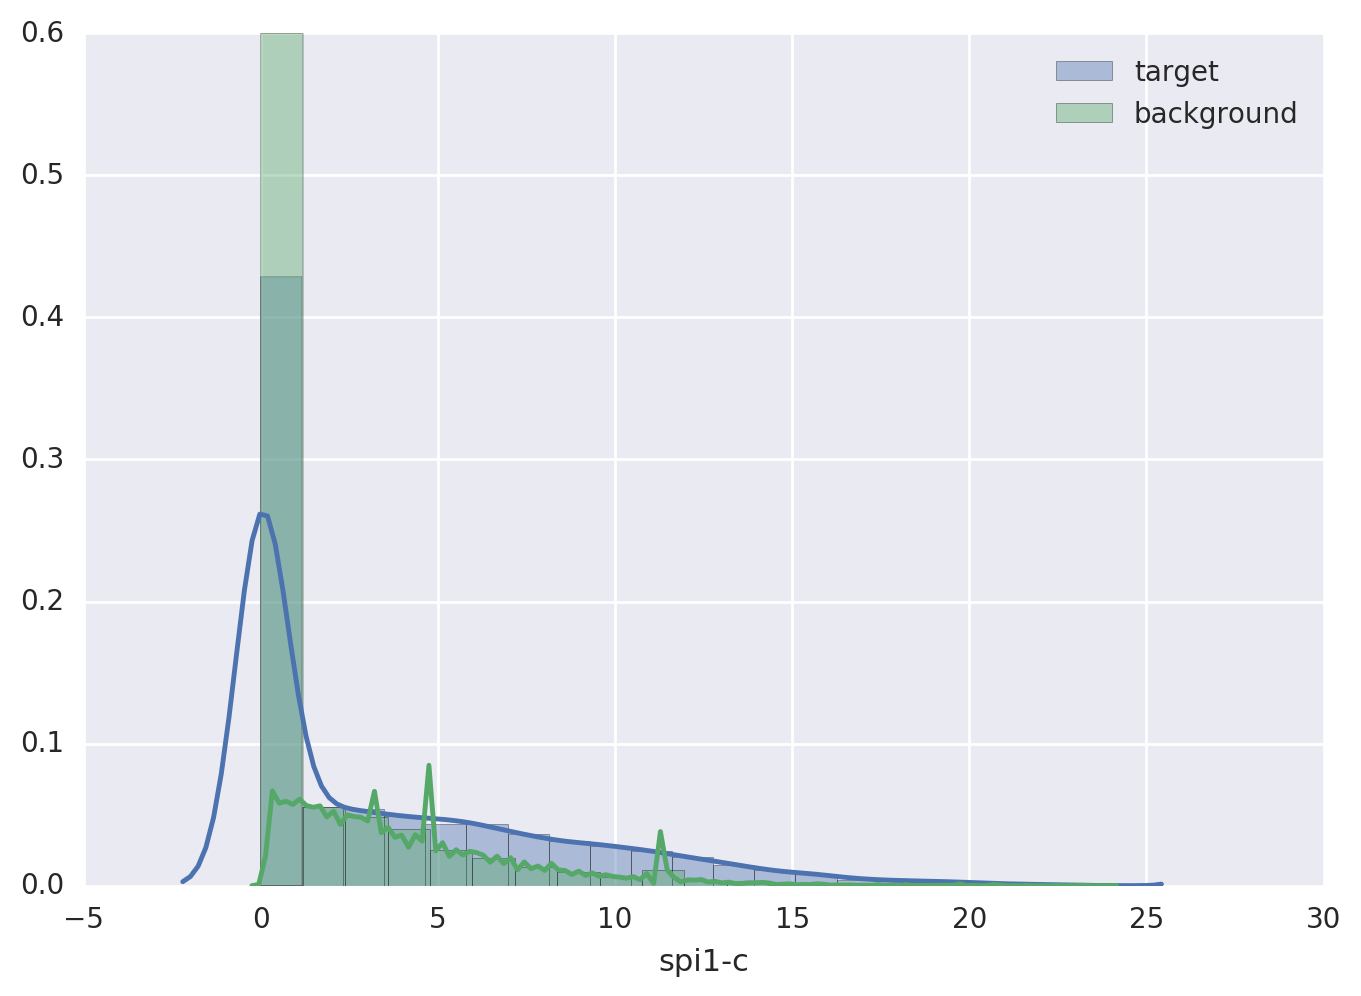

In [109]:
sns.distplot(all_score_frame[all_score_frame.index.isin(
            summary_frame[summary_frame['c57bl6_cjun_veh'] > 0].index.values)]['spi1-c'], label='target',
            bins=20)
sns.distplot(all_score_frame[all_score_frame.index.isin(motif_score_background_frame.index.values)]['spi1-c'], 
             label='background', bins=20)
plt.legend()

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


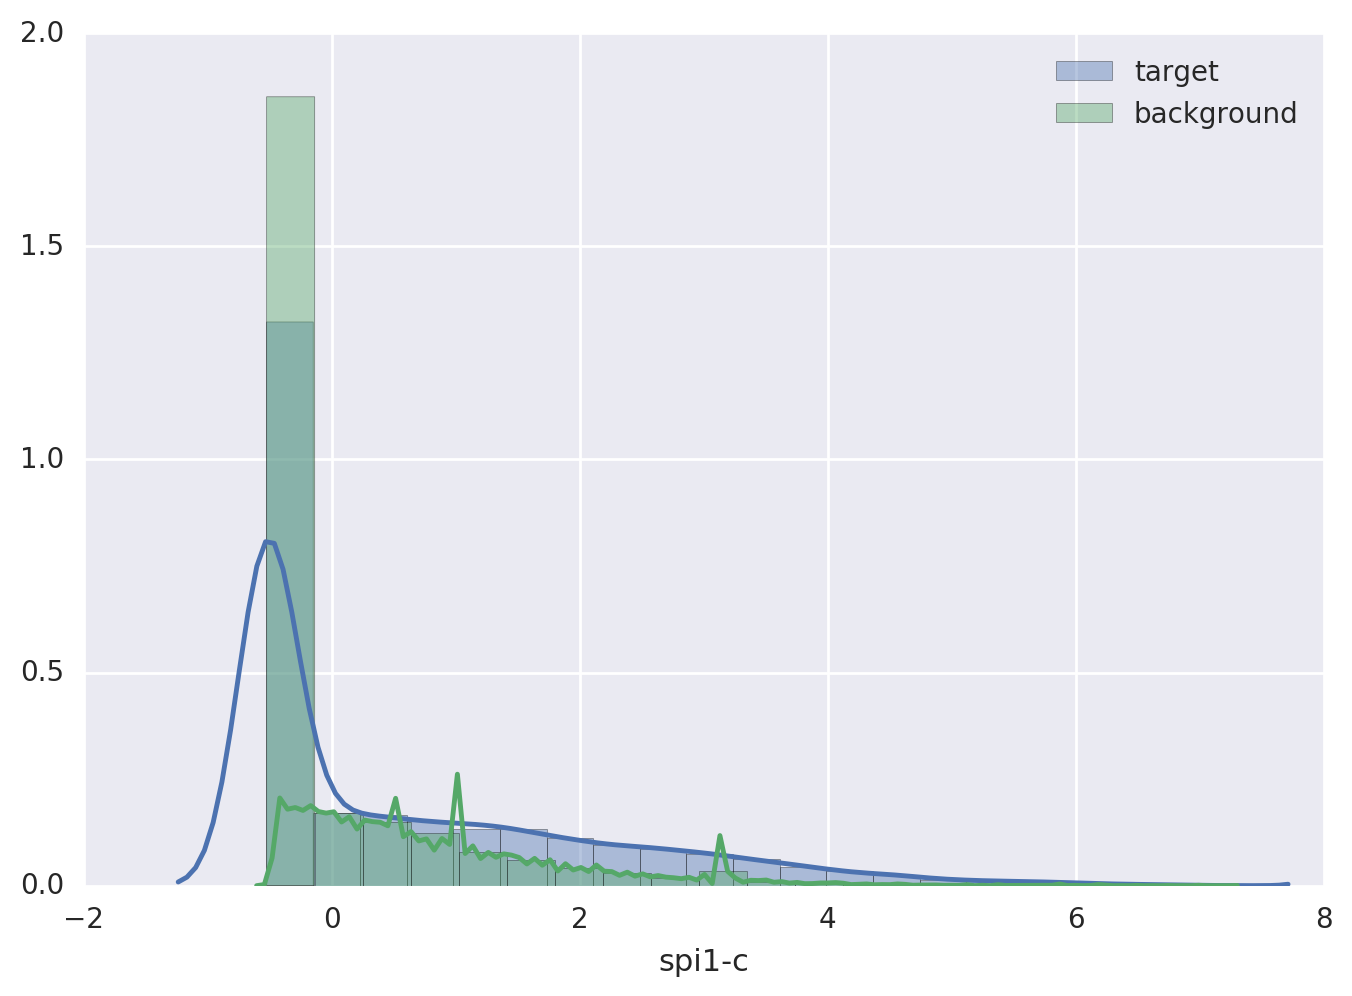

In [110]:
sns.distplot(all_standardized_score_frame[all_standardized_score_frame.index.isin(
            summary_frame[summary_frame['c57bl6_cjun_veh'] > 0].index.values)]['spi1-c'], label='target',
            bins=20)
sns.distplot(all_standardized_score_frame[all_standardized_score_frame.index.isin(motif_score_background_frame.index.values)]
             ['spi1-c'], label='background', bins=20)
plt.legend()

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


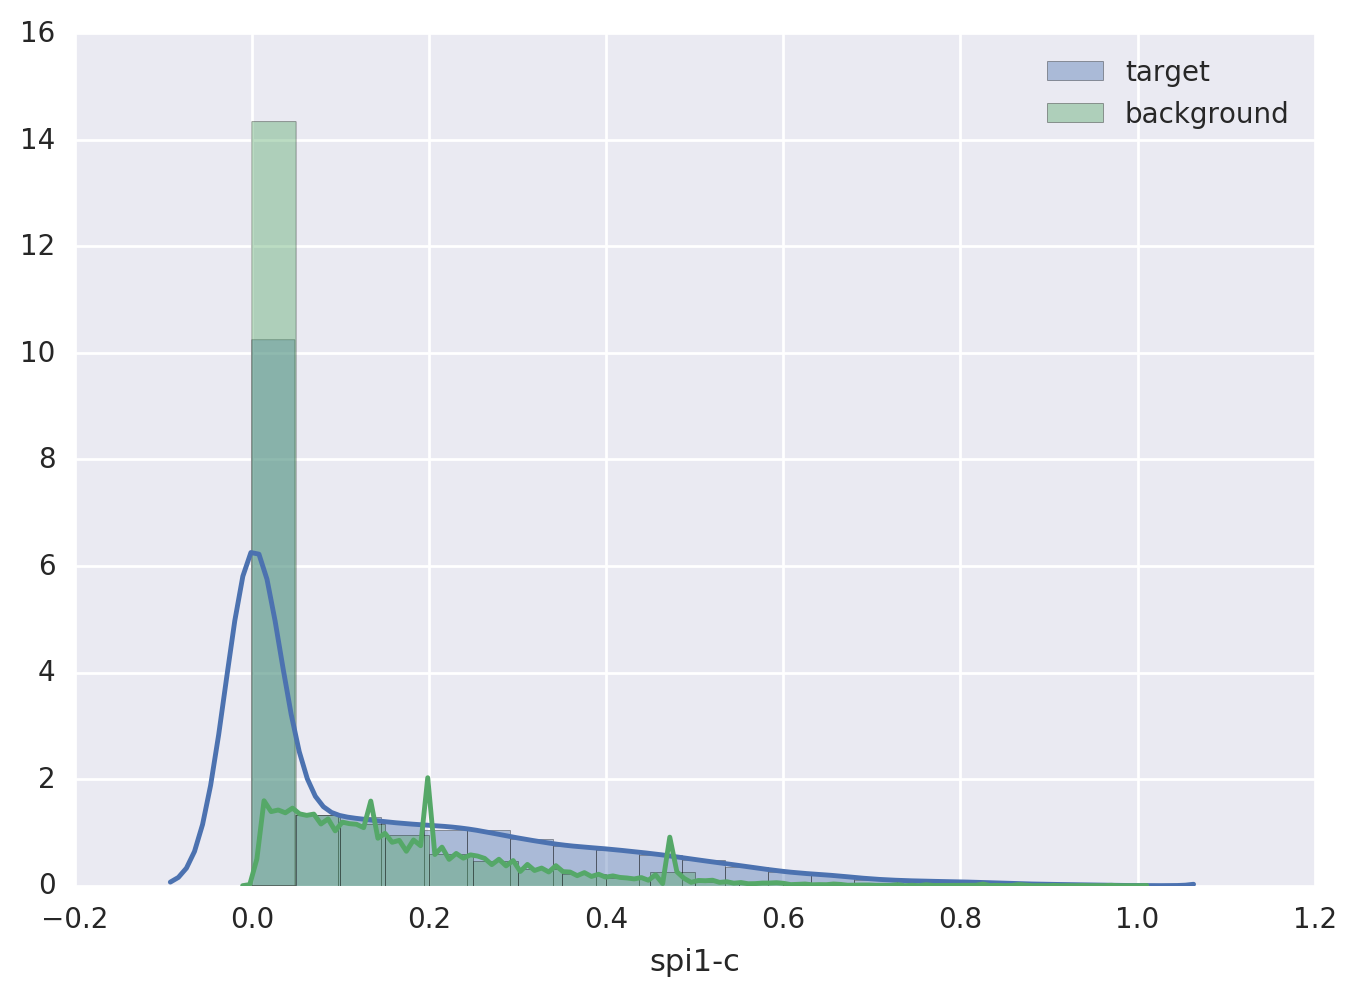

In [113]:
sns.distplot(all_normed_score_frame[all_normed_score_frame.index.isin(
            summary_frame[summary_frame['c57bl6_cjun_veh'] > 0].index.values)]['spi1-c'], label='target',
            bins=20)
sns.distplot(all_normed_score_frame[all_normed_score_frame.index.isin(motif_score_background_frame.index.values)]['spi1-c'], label='background', bins=20)
plt.legend()

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


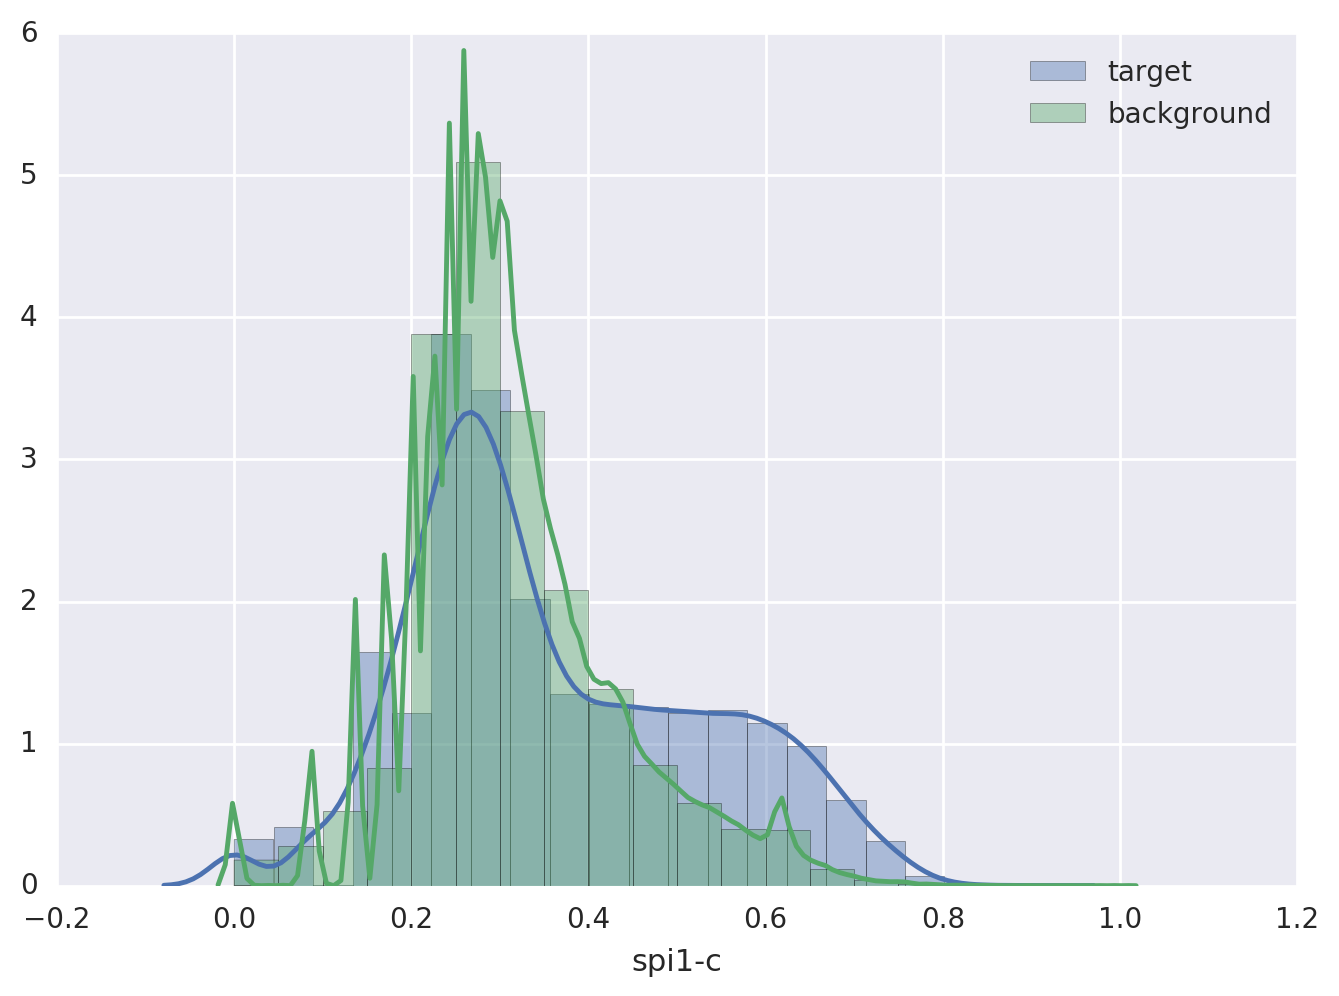

In [114]:
sns.distplot(all_normed_summedScore_frame[all_normed_summedScore_frame.index.isin(
            summary_frame[summary_frame['c57bl6_cjun_veh'] > 0].index.values)]['spi1-c'], label='target',
            bins=20)
sns.distplot(all_normed_summedScore_frame[all_normed_summedScore_frame.index.isin(motif_score_background_frame.index.values)]
             ['spi1-c'], label='background', bins=20)
plt.legend()

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


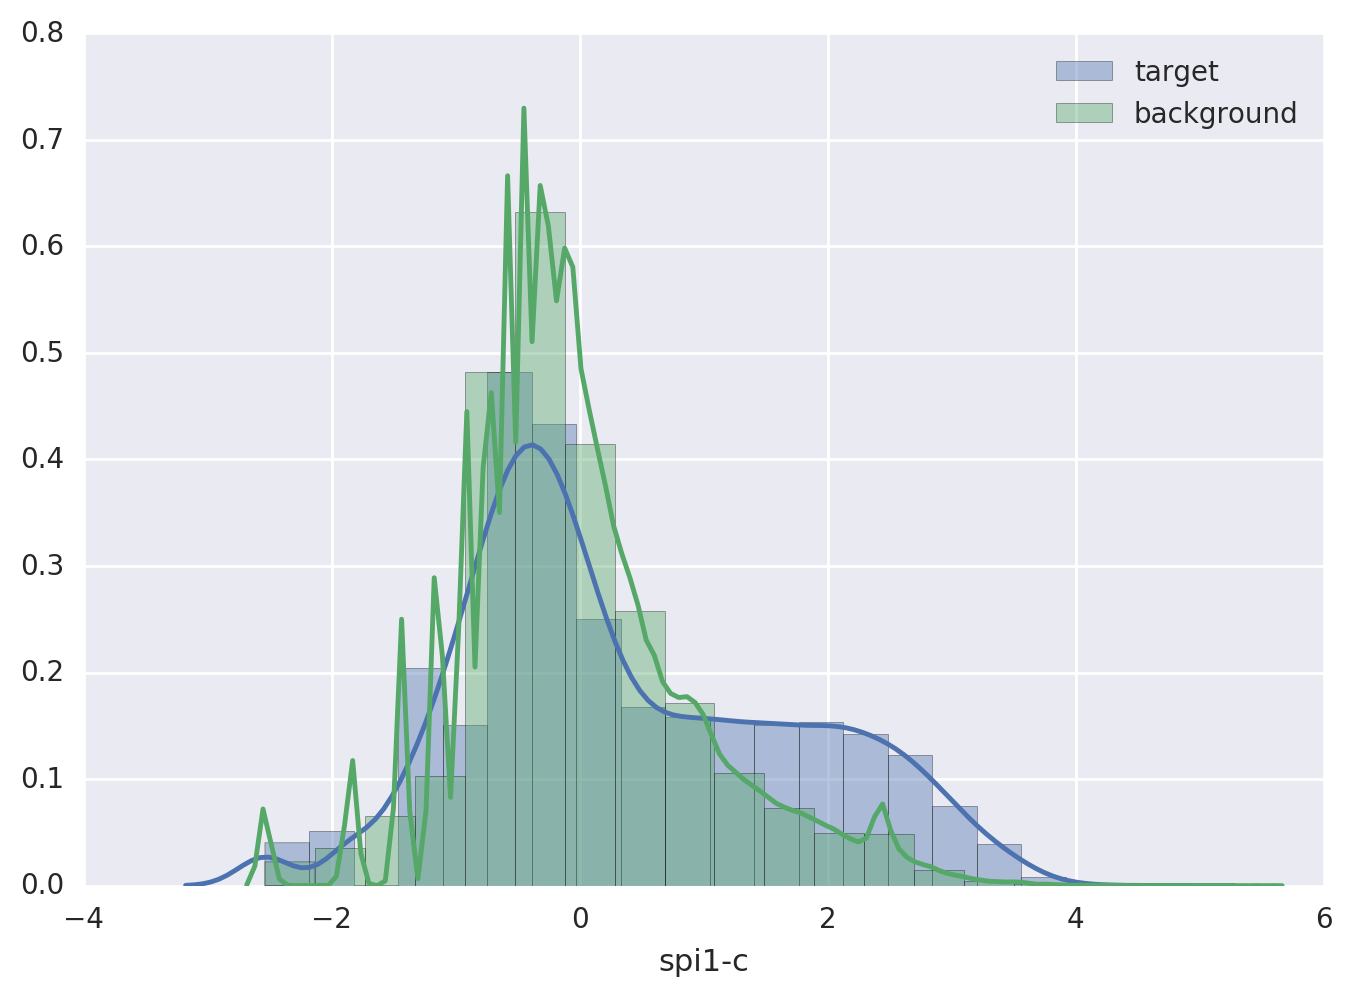

In [115]:
sns.distplot(all_standardized_summedScore_frame[all_standardized_summedScore_frame.index.isin(
            summary_frame[summary_frame['c57bl6_cjun_veh'] > 0].index.values)]['spi1-c'], label='target',
            bins=20)
sns.distplot(all_standardized_summedScore_frame[all_standardized_summedScore_frame.index.isin(motif_score_background_frame.index.values)]
             ['spi1-c'], label='background', bins=20)
plt.legend()

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


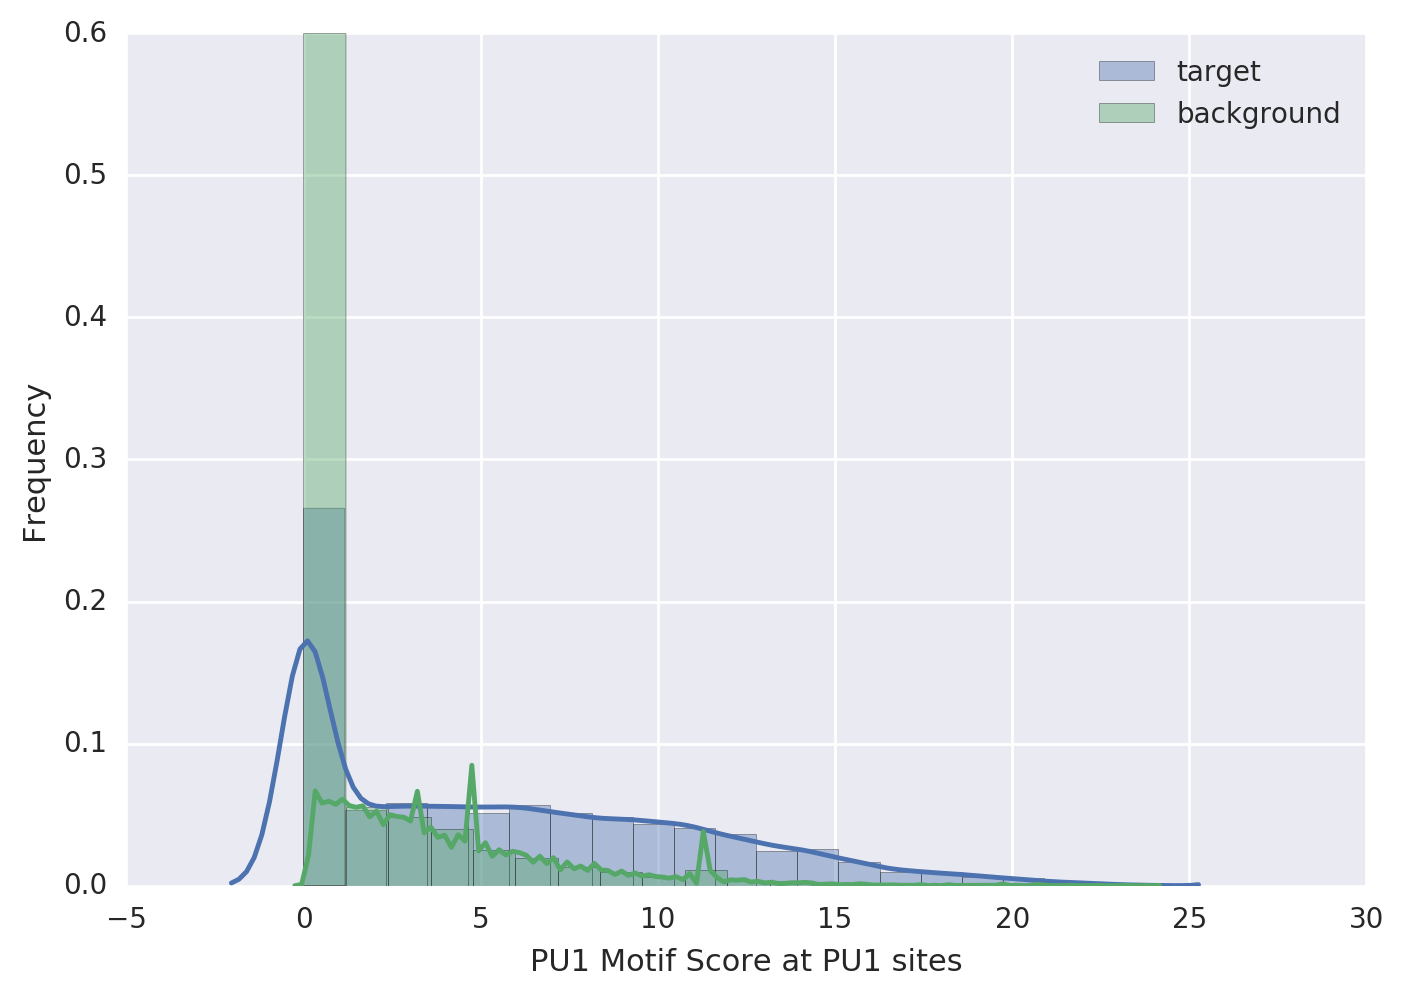

In [89]:
sns.distplot(motif_score_frame[motif_score_frame.index.isin(
            summary_frame[summary_frame['c57bl6_pu1_veh'] > 0].index.values)]['spi1-c'], label='target',
            bins=20)
sns.distplot(motif_score_background_frame['spi1-c'], label='background', bins=20)
plt.xlabel('PU1 Motif Score at PU1 sites')
plt.ylabel('Frequency')
plt.legend()